In [1]:
#Don't forget to save your work to your local computer and push to GitHub.
#File -> Download as -> Notebook
#Move file from download folder to local repo clone
#git add filename.ipynb
#git commit -m "put a specific and informative message here of what you worked on"
#git push

# Import and Prepare Dataset - Custom Concept Set for Birth and Preterm Birth 

In this section:  
Import data; rename to long_data (in long format)   
Remove irrelevant values for "condition" (e.g. "second trimester pregnancy" is too vague)    
Convert datetime cells to date only

## Import dataset

In [2]:
import pandas
import pandas as pd
import os
import numpy as np
import time

# This query represents dataset "Concept Set Exploration" for domain "condition" and was generated for All of Us Controlled Tier Dataset v7
dataset_87730747_condition_sql = """
    SELECT
        c_occurrence.person_id,
        c_standard_concept.concept_name as standard_concept_name,
        c_occurrence.condition_start_datetime 
    FROM
        ( SELECT
            * 
        FROM
            `""" + os.environ["WORKSPACE_CDR"] + """.condition_occurrence` c_occurrence 
        WHERE
            (
                condition_concept_id IN  (
                    SELECT
                        DISTINCT c.concept_id 
                    FROM
                        `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` c 
                    JOIN
                        (
                            select
                                cast(cr.id as string) as id 
                            FROM
                                `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` cr 
                            WHERE
                                concept_id IN (
                                    36712702, 4014295, 432441, 44784550, 45757175, 45757176
                                ) 
                                AND full_text LIKE '%_rank1]%'
                        ) a 
                            ON (
                                c.path LIKE CONCAT('%.',
                            a.id,
                            '.%') 
                            OR c.path LIKE CONCAT('%.',
                            a.id) 
                            OR c.path LIKE CONCAT(a.id,
                            '.%') 
                            OR c.path = a.id) 
                        WHERE
                            is_standard = 1 
                            AND is_selectable = 1
                        )
                )  
                AND (
                    c_occurrence.PERSON_ID IN (
                        SELECT
                            distinct person_id  
                        FROM
                            `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` cb_search_person  
                        WHERE
                            cb_search_person.person_id IN (
                                SELECT
                                    criteria.person_id 
                                FROM
                                    (SELECT
                                        DISTINCT person_id,
                                        entry_date,
                                        concept_id 
                                    FROM
                                        `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_all_events` 
                                    WHERE
                                        (
                                            concept_id IN (
                                                SELECT
                                                    DISTINCT c.concept_id 
                                                FROM
                                                    `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` c 
                                                JOIN
                                                    (
                                                        select
                                                            cast(cr.id as string) as id 
                                                        FROM
                                                            `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` cr 
                                                        WHERE
                                                            concept_id IN (36712702, 45757176, 4014295) 
                                                            AND full_text LIKE '%_rank1]%'
                                                    ) a 
                                                        ON (
                                                            c.path LIKE CONCAT('%.',
                                                        a.id,
                                                        '.%') 
                                                        OR c.path LIKE CONCAT('%.',
                                                        a.id) 
                                                        OR c.path LIKE CONCAT(a.id,
                                                        '.%') 
                                                        OR c.path = a.id) 
                                                    WHERE
                                                        is_standard = 1 
                                                        AND is_selectable = 1
                                                    ) 
                                                    AND is_standard = 1 
                                            )
                                        ) criteria 
                                    ) ))
                        ) c_occurrence 
                    LEFT JOIN
                        `""" + os.environ["WORKSPACE_CDR"] + """.concept` c_standard_concept 
                            ON c_occurrence.condition_concept_id = c_standard_concept.concept_id"""

dataset_87730747_condition_df = pandas.read_gbq(
    dataset_87730747_condition_sql,
    dialect="standard",
    use_bqstorage_api=("BIGQUERY_STORAGE_API_ENABLED" in os.environ),
    progress_bar_type="tqdm_notebook")

dataset_87730747_condition_df.head(5)

Downloading:   0%|          | 0/390805 [00:00<?, ?rows/s]

,person_id,standard_concept_name,condition_start_datetime
0,3479822,"Gestation period, 14 weeks",2019-07-19 03:59:08+00:00
1,4077275,"Gestation period, 14 weeks",2018-09-29 11:00:55+00:00
2,1340430,"Gestation period, 14 weeks",2018-12-12 09:45:51+00:00
3,2030520,"Gestation period, 14 weeks",2016-09-15 22:10:28+00:00
4,3461398,"Gestation period, 14 weeks",2019-01-13 09:26:37+00:00


## Rename dataset
Rename and inspect dataset  
Data in long format (multiple rows per person_id)

In [3]:
raw_birth_data = dataset_87730747_condition_df
print(raw_birth_data.info)
raw_birth_data.sample(3)


<bound method DataFrame.info of         person_id       standard_concept_name  condition_start_datetime
0         3479822  Gestation period, 14 weeks 2019-07-19 03:59:08+00:00
1         4077275  Gestation period, 14 weeks 2018-09-29 11:00:55+00:00
2         1340430  Gestation period, 14 weeks 2018-12-12 09:45:51+00:00
3         2030520  Gestation period, 14 weeks 2016-09-15 22:10:28+00:00
4         3461398  Gestation period, 14 weeks 2019-01-13 09:26:37+00:00
...           ...                         ...                       ...
390800    1777594   Third trimester pregnancy 2019-10-10 14:43:00+00:00
390801    1777594   Third trimester pregnancy 2019-10-03 14:57:00+00:00
390802    8704017   Third trimester pregnancy 2016-12-16 14:30:00+00:00
390803    2150328   Third trimester pregnancy 2020-07-31 14:54:00+00:00
390804    2727267   Gestation period, 8 weeks 2019-05-17 14:59:00+00:00

[390805 rows x 3 columns]>


,person_id,standard_concept_name,condition_start_datetime
84213,2080022,"Gestation period, 20 weeks",2018-05-10 04:00:00+00:00
369759,1891643,"Gestation period, 8 weeks",2018-05-11 10:44:09+00:00
262231,5728142,"Gestation period, 39 weeks",2019-10-24 00:00:00+00:00


## Drop irrelevant concepts from standard_concept_name

Review values of standard_concept_name and remove irrelevant entries (too vague, not used in analysis, e.g. "gestation less than 20 weeks")

In [4]:
#unique_values = raw_birth_data['standard_concept_name'].unique()

#print("List of all possible values for column 'standard_concept_name':")
#for value in unique_values:
    #print(value)

#Prepare list of values to drop    
values_to_drop = ['Gestation less than 20 weeks', 'Gestation less than 9 weeks']
values_to_drop += ['Finding of length of gestation', 'Gestation less than 24 weeks']
values_to_drop += ['First trimester pregnancy', 'Second trimester pregnancy', 'Third trimester pregnancy']

# Use the 'drop' method to remove rows with specific values in 'standard_concept_name'
raw_birth_data = raw_birth_data[~raw_birth_data['standard_concept_name'].isin(values_to_drop)]

#This filtered df is created by making a boolean list of values_to_drop found in the column 'standard_concept_name'
#The tilde switches this from True to False so that we are applying the opposite of the boolean list to the df
#in order to create the new df


In [5]:
#Convert condition_start_datetime and end_datetime cells to contain only date information and not time, 
#as time is irrelevant to most of our calculations

# Convert the datetime column to a datetime type
raw_birth_data.loc[:,'condition_start_datetime'] = pd.to_datetime(raw_birth_data['condition_start_datetime'])

#Create a new date only column
raw_birth_data.loc[:,'condition_start_date'] = raw_birth_data['condition_start_datetime'].dt.date

#print("New column condition_start_date without time")
raw_birth_data.sample(3)



/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


,person_id,standard_concept_name,condition_start_datetime,condition_start_date
256605,3210620,"Gestation period, 40 weeks",2019-05-13 04:00:00+00:00,2019-05-13
10662,1404456,"Gestation period, 27 weeks",2018-12-17 00:00:00+00:00,2018-12-17
161853,1403385,Single live birth,2021-12-17 00:00:00+00:00,2021-12-17


# Remove duplicate entries

Remove duplicates of person_id, birth_concept, and condition_start_date.

In [6]:
birth_concepts = ['Single live birth', 'Preterm spontaneous labor with preterm delivery', 'Term pregnancy', 
                  'Preterm labor in second trimester with preterm delivery in second trimester', 
                  'Preterm labor in third trimester with preterm delivery in third trimester',
                  'Preterm labor with preterm delivery'
                 ]
# Step 1: Create a subset of raw_birth_data where standard_concept_name includes only those values in birth_concepts
subset_birth_concepts = raw_birth_data[raw_birth_data['standard_concept_name'].isin(birth_concepts)]

# Step 2: Remove duplicates that have the same person_id and condition_start_date
subset_birth_concepts_no_duplicates = subset_birth_concepts.drop_duplicates(subset=['person_id', 'condition_start_date'], keep='first')

# Step 3: Recombine df with the subset of raw_birth_data where standard_concept_name includes only those values NOT in birth_concepts
subset_not_birth_concepts = raw_birth_data[~raw_birth_data['standard_concept_name'].isin(birth_concepts)]
combined_data = pd.concat([subset_not_birth_concepts, subset_birth_concepts_no_duplicates], ignore_index=True)

filtered_birth_data = combined_data.copy()

print(filtered_birth_data.info)
filtered_birth_data.sample(20)

<bound method DataFrame.info of         person_id                              standard_concept_name  \
0         3479822                         Gestation period, 14 weeks   
1         4077275                         Gestation period, 14 weeks   
2         1340430                         Gestation period, 14 weeks   
3         2030520                         Gestation period, 14 weeks   
4         3461398                         Gestation period, 14 weeks   
...           ...                                                ...   
173722    1342934  Preterm labor in third trimester with preterm ...   
173723    3179783  Preterm labor in third trimester with preterm ...   
173724    9180628  Preterm labor in third trimester with preterm ...   
173725    2419405  Preterm labor in third trimester with preterm ...   
173726    4231691  Preterm labor in third trimester with preterm ...   

               condition_start_datetime condition_start_date  
0             2019-07-19 03:59:08+00:00 

,person_id,standard_concept_name,condition_start_datetime,condition_start_date
34473,3459258,"Gestation period, 33 weeks",2019-04-08 16:31:00.381000+00:00,2019-04-08
39873,2709897,"Gestation period, 26 weeks",2019-01-25 18:39:00.100000+00:00,2019-01-25
15638,1249261,"Gestation period, 37 weeks",2020-04-06 04:00:00+00:00,2020-04-06
4070,2731243,"Gestation period, 18 weeks",2019-11-26 05:59:59+00:00,2019-11-26
29838,1554835,"Gestation period, 38 weeks",2018-11-08 05:00:00+00:00,2018-11-08
40024,2005807,"Gestation period, 26 weeks",2019-11-23 00:00:00+00:00,2019-11-23
89493,3494247,"Gestation period, 30 weeks",2021-12-05 05:00:00+00:00,2021-12-05
33685,7506363,"Gestation period, 33 weeks",2022-01-31 05:00:00+00:00,2022-01-31
48798,1528508,"Gestation period, 34 weeks",2015-12-01 05:00:00+00:00,2015-12-01
66669,7729456,"Gestation period, 36 weeks",2021-06-21 18:20:00+00:00,2021-06-21


## Explore remaining entries 
- Making sure above filter is working 
- Instances of duplicate person_id and standard_concept_name that differ in condition_start_datetime (how far apart occurring?)
    - Need to discriminate between these and accurate entries after calculating conception and gestational age further in notebook

# Calculate conception date based on observations of gestational length
Use entries of 'standard_concept_name' to calculate date of conception. (ex. Gestation 8 weeks, Gestation 38 weeks).  

In this section:  
- Create a dictionary to view how many times different 'standard_concept_name's are used in the dataset to see which we will need to use for calculations.

- Create a loop to calculate conception date for every instance of 'Gestation period, x weeks' entry in 'standard_concept_name' and populate new column called "conception_date".

- Explore conception date variances / reasons / how to handle discrepancies. 

Note: Through this process I found that because of issues with medical records, our most accurate approach is to start with the most recent medical record of gestation period, e.g. 40 weeks, then look for 39 weeks, and so on. If we start with 8 weeks for example, then we sometimes label a birth as over-term by weeks or months because the instance of 8 week gestation length was for a miscarriage, and then no further records available until the next birth. 


## Create a dictionary to store standard_concept_names and record how often each one is used in df


In [7]:
#view all entries for standard_concept_name

#Create a dictionary to store concept names
concept_dict = {}

#Iterate through column 'standard_concept_name' 
for concept in filtered_birth_data['standard_concept_name']:
    if concept in concept_dict:
        concept_dict[concept] += 1
    else:
        concept_dict[concept] = 1

#print nicely
for key, value in concept_dict.items():
    print(f'{key}: {value}')


Gestation period, 14 weeks: 1509
Gestation period, 25 weeks: 2077
Gestation period, 18 weeks: 3506
Gestation period, 13 weeks: 2482
Gestation period, 27 weeks: 2563
Gestation period, 37 weeks: 9435
Gestation period, 38 weeks: 9384
Gestation period, 16 weeks: 2068
Gestation period, 33 weeks: 4885
Gestation period, 42 weeks: 18
Gestation period, 41 weeks: 1333
Gestation period, 26 weeks: 2440
Gestation period, 10 weeks: 2112
Gestation period, 11 weeks: 3704
Gestation period, 9 weeks: 39
Gestation period, 34 weeks: 5816
Gestation period, 19 weeks: 3468
Gestation period, 22 weeks: 2541
Gestation period, 12 weeks: 4600
Gestation period, 36 weeks: 8688
Gestation period, 17 weeks: 1822
Gestation period, 21 weeks: 2622
Gestation period, 23 weeks: 2219
Gestation period, 15 weeks: 1493
Gestation period, 20 weeks: 4013
Gestation period, 28 weeks: 3839
Gestation period, 31 weeks: 3512
Gestation period, 30 weeks: 3415
Gestation period, 35 weeks: 6198
Gestation period, 29 weeks: 2848
Gestation perio

## Create a function to calculate conception date based on standard_concept_name that provides gestational age in weeks.

In [8]:
#Create code to calculate conception date from standard_concept_name that gives gestational age

from datetime import timedelta

# Define a function to calculate the conception date
def calculate_conception(row):
    # Split the 'standard_concept_name' to extract the number of weeks
    concept_name_parts = row['standard_concept_name'].split()
    if len(concept_name_parts) == 4 and concept_name_parts[0] == "Gestation":
        try:
            weeks = int(concept_name_parts[2])
            # Calculate the conception date by subtracting 'weeks' from 'condition_start_datetime'
            conception_date = row['condition_start_date'] - timedelta(weeks=weeks)
            return conception_date
        except ValueError:
            pass
    return None

# Apply the function to create and fill the 'conception_date' column
filtered_birth_data.loc[:,'conception_date'] = filtered_birth_data.apply(calculate_conception, axis=1).copy()

conception_birth_data = filtered_birth_data.copy()

print(conception_birth_data.info)
conception_birth_data.sample(10)



<bound method DataFrame.info of         person_id                              standard_concept_name  \
0         3479822                         Gestation period, 14 weeks   
1         4077275                         Gestation period, 14 weeks   
2         1340430                         Gestation period, 14 weeks   
3         2030520                         Gestation period, 14 weeks   
4         3461398                         Gestation period, 14 weeks   
...           ...                                                ...   
173722    1342934  Preterm labor in third trimester with preterm ...   
173723    3179783  Preterm labor in third trimester with preterm ...   
173724    9180628  Preterm labor in third trimester with preterm ...   
173725    2419405  Preterm labor in third trimester with preterm ...   
173726    4231691  Preterm labor in third trimester with preterm ...   

               condition_start_datetime condition_start_date conception_date  
0             2019-07-19

,person_id,standard_concept_name,condition_start_datetime,condition_start_date,conception_date
31018,3299964,"Gestation period, 16 weeks",2017-11-13 00:00:00+00:00,2017-11-13,2017-07-24
66819,3098598,"Gestation period, 36 weeks",2021-04-20 05:59:59+00:00,2021-04-20,2020-08-11
78374,1108149,"Gestation period, 21 weeks",2018-04-19 04:00:00+00:00,2018-04-19,2017-11-23
28659,9632706,"Gestation period, 38 weeks",2016-12-09 05:00:00+00:00,2016-12-09,2016-03-18
122104,3483988,"Gestation period, 39 weeks",2017-05-11 05:00:00+00:00,2017-05-11,2016-08-11
124753,1056354,"Gestation period, 39 weeks",2019-07-17 16:54:00+00:00,2019-07-17,2018-10-17
20385,8451091,"Gestation period, 37 weeks",2022-03-02 00:00:00+00:00,2022-03-02,2021-06-16
45828,1822393,"Gestation period, 11 weeks",2017-01-18 05:00:00+00:00,2017-01-18,2016-11-02
22579,3143199,"Gestation period, 38 weeks",2019-02-13 14:50:26+00:00,2019-02-13,2018-05-23
151754,1885051,Single live birth,2020-06-24 11:04:00+00:00,2020-06-24,None


# Calculate Gestational Age

In this section:

Calculate Gestational Age
- Sort by person_id, condition_start_date, and then standard_concept_name. Sorting by the latter will make sure that for the same date, all Gestational period entries will occur before the birth entry. 

- Calculate gestational_age_at_birth by subtracting condition_start_time for "Single live birth" from conception_date from measurements most accurate for determining minimum gestation length (e.g. 42 weeks, then 41, 40, etc).     

Explore entries
- Exploration of person_ids that have gestational ages that are unreasonably high (above 42 weeks) or low (less than 8 weeks and negaative entries, indicating that conception date was pulled from another person or another pregnancy. 


## Calculate gestational age at birth for instances of birth concepts

(condition_start_date for birth concept - conception_date)


In [9]:
#Apply loop to calculate gestional_age_at_birth to birth concepts that have gestational data available.
conception_copy = conception_birth_data.copy()

# Start measuring execution time
start_time = time.time()

# Sort the DataFrame by person_id and condition_start_date
conception_copy = conception_copy.sort_values(by=['person_id', 'condition_start_date', 'standard_concept_name', 'condition_start_datetime'])

birth_concepts = ['Single live birth', 'Preterm spontaneous labor with preterm delivery', 'Term pregnancy', 
                  'Preterm labor in second trimester with preterm delivery in second trimester', 
                  'Preterm labor in third trimester with preterm delivery in third trimester',
                  'Preterm labor with preterm delivery'
                 ]

for concept in birth_concepts:
    # Initialize a dictionary to store the most recent "Gestation period" and conception date for each person_id
    gestational_info = {}

    # Initialize a list to store birth dates
    birth_dates = []

    # Iterate through the DataFrame
    for idx, row in conception_copy.iterrows():
        person_id = row['person_id']

        if person_id not in gestational_info:
            gestational_info[person_id] = {'gestational_period': None, 'conception_date': None}

        current_gestational_period = gestational_info[person_id]['gestational_period']
        conception_date = gestational_info[person_id]['conception_date']

        if row['standard_concept_name'].startswith('Gestation period'):
            # Update the current gestational period
            gestational_info[person_id]['gestational_period'] = row['standard_concept_name']
            gestational_info[person_id]['conception_date'] = row['conception_date']

        if row['standard_concept_name'] == concept:
            if conception_date is not None:
                birth_dates.append((idx, row['condition_start_date']))
                last_idx, last_birth_date = birth_dates[-1]
                gestational_age = (pd.to_datetime(last_birth_date) - pd.to_datetime(conception_date)).days / 7
                conception_copy.at[last_idx, 'gestational_age_at_birth'] = gestational_age
                conception_date = None


# End measuring execution time
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Execution time: {elapsed_time} seconds")

# Display a sample of the updated DataFrame
gestational_age_data = conception_copy.copy()
gestational_age_data.sample(10)

Execution time: 106.63420820236206 seconds


,person_id,standard_concept_name,condition_start_datetime,condition_start_date,conception_date,gestational_age_at_birth
67908,1947703,"Gestation period, 36 weeks",2018-08-21 00:00:00+00:00,2018-08-21,2017-12-12,NaN
138815,1008853,Single live birth,2013-10-24 05:00:00+00:00,2013-10-24,None,NaN
21719,1257539,"Gestation period, 38 weeks",2020-01-12 00:00:00+00:00,2020-01-12,2019-04-21,NaN
67153,2013361,"Gestation period, 36 weeks",2017-10-17 05:59:59+00:00,2017-10-17,2017-02-07,NaN
44654,1671456,"Gestation period, 11 weeks",2020-03-03 05:59:59+00:00,2020-03-03,2019-12-17,NaN
84106,1594519,"Gestation period, 20 weeks",2021-01-04 14:46:00+00:00,2021-01-04,2020-08-17,NaN
91720,1975731,"Gestation period, 30 weeks",2019-02-27 05:00:00+00:00,2019-02-27,2018-08-01,NaN
168653,2126341,Single live birth,2021-01-30 17:37:00+00:00,2021-01-30,None,39.0
93273,1868289,"Gestation period, 31 weeks",2017-02-28 00:00:00+00:00,2017-02-28,2016-07-26,NaN
141075,1023801,Single live birth,2009-12-10 06:00:00+00:00,2009-12-10,None,NaN


### Gestational Age Min/Max and Number of Entries Added

In [10]:
# Calculate min and max values of 'gestational_age_at_birth'
min_value = gestational_age_data['gestational_age_at_birth'].min()
max_value = gestational_age_data['gestational_age_at_birth'].max()

print(f"Range of gestational_age_at_birth: {min_value} to {max_value}")

# Calculate number of gestational ages added
added_gestational_ages = gestational_age_data['gestational_age_at_birth'].count()
print("Number of gestational ages added:", added_gestational_ages)

# Remove gestational age == na 
removed_entries_count = len(gestational_age_data)

for concept in birth_concepts:
    gestational_age_data = gestational_age_data[~((gestational_age_data['standard_concept_name'] == concept) & gestational_age_data['gestational_age_at_birth'].isna())]

removed_entries_count -= len(gestational_age_data)

print(f"{removed_entries_count} n/a entries were removed from the column gestational age at birth.")

Range of gestational_age_at_birth: 8.0 to 320.2857142857143
Number of gestational ages added: 21533
14583 n/a entries were removed from the column gestational age at birth.


## Dataset observations (also, remove gestational ages less than 22 and more than 45 weeks)

In [11]:
#Checking numbers to see how the loop is working. 

#Missing gestation_age_at_birth (for example, birth occurred but no previous records attached)
birth_concepts = ['Single live birth', 'Preterm spontaneous labor with preterm delivery', 'Term pregnancy', 
                  'Preterm labor in second trimester with preterm delivery in second trimester', 
                  'Preterm labor in third trimester with preterm delivery in third trimester',
                  'Preterm labor with preterm delivery'
                 ]

negative_gestational_age = len(gestational_age_data[gestational_age_data['gestational_age_at_birth'] < 0])
greater_than_45_weeks = len(gestational_age_data[gestational_age_data['gestational_age_at_birth'] > 45])
lessthan22_gestational_age = len(gestational_age_data[gestational_age_data['gestational_age_at_birth'] < 22])

#Filter the DataFrame for gestational ages at birth between 22 and <=45 weeks
filtered_df_copy = gestational_age_data[(gestational_age_data['gestational_age_at_birth'] >= 22) & (gestational_age_data['gestational_age_at_birth'] <= 45)]

births_full_term = len(filtered_df_copy[(filtered_df_copy['gestational_age_at_birth'] >= 37)])
births_under_37_weeks = len(filtered_df_copy[(filtered_df_copy['gestational_age_at_birth'] < 37)])
births_late_preterm = len(filtered_df_copy[(filtered_df_copy['gestational_age_at_birth'] >= 32) & (filtered_df_copy['gestational_age_at_birth'] < 37)])
births_very_preterm = len(filtered_df_copy[(filtered_df_copy['gestational_age_at_birth'] >= 28) & (filtered_df_copy['gestational_age_at_birth'] < 32)])
births_extremely_preterm = len(filtered_df_copy[(filtered_df_copy['gestational_age_at_birth'] < 28)])

number_unique_ids = len(filtered_df_copy['person_id'].unique())

# Display the counts of entries deleted
print("Number of entries with negative gestational age deleted:", negative_gestational_age)
print("Number of entries with gestational age greater than 45 weeks deleted:", greater_than_45_weeks)
print("Number of entries with gestational age less than 22 weeks deleted", lessthan22_gestational_age)
print("Number of births that are full term >= 37 weeks:", births_full_term)
print("Number of births that are any class of Preterm:", births_under_37_weeks)
print("Number of births that are Late Preterm >= 32 and < 37 weeks:", births_late_preterm)
print("Number of births that are Very Preterm >= 28 weeks and < 32 weeks:", births_very_preterm)
print("Number of births that are Extremely Preterm < 28 weeks:", births_extremely_preterm)
print("Total number of births:", (births_full_term + births_under_37_weeks))
print("Percentage of births that are any class of preterm:", births_under_37_weeks / (births_full_term + births_under_37_weeks)  * 100)
print("Number of unique person_ids:", number_unique_ids)

min_gestational_age = filtered_df_copy['gestational_age_at_birth'].min()
print(f"The minimum gestational age at birth in this dataset is: {min_gestational_age} weeks")

max_gestational_age = filtered_df_copy['gestational_age_at_birth'].max()
print(f"The max gestational age at birth in this dataset is: {max_gestational_age} weeks")

gestational_age_data = filtered_df_copy.copy()

Number of entries with negative gestational age deleted: 0
Number of entries with gestational age greater than 45 weeks deleted: 79
Number of entries with gestational age less than 22 weeks deleted 142
Number of births that are full term >= 37 weeks: 18309
Number of births that are any class of Preterm: 3003
Number of births that are Late Preterm >= 32 and < 37 weeks: 2342
Number of births that are Very Preterm >= 28 weeks and < 32 weeks: 423
Number of births that are Extremely Preterm < 28 weeks: 238
Total number of births: 21312
Percentage of births that are any class of preterm: 14.090653153153154
Number of unique person_ids: 11959
The minimum gestational age at birth in this dataset is: 22.0 weeks
The max gestational age at birth in this dataset is: 44.142857142857146 weeks


# Classify births into term or preterm class based on gestational age at birth

Term >= 37 weeks  
37 weeks > Preterm >= 22 weeks

In [12]:
gestational_age_data = filtered_df_copy.copy()

In [13]:
# Create a new column "birth_class" and set it to 'Unknown' initially
gestational_age_data['birth_class'] = 'Unknown'

# Fill in the birth class column based on gestational age at birth.
gestational_age_data.loc[(gestational_age_data['gestational_age_at_birth'] >= 37), 'birth_class'] = 'Term'
gestational_age_data.loc[(gestational_age_data['gestational_age_at_birth'] >= 22) & (gestational_age_data['gestational_age_at_birth'] < 37), 'birth_class'] = 'Preterm'

#Remove all lines that contain birth class == Unknown (e.g. remove gestational findings, etc)
birth_class_data = gestational_age_data[gestational_age_data['birth_class'] != 'Unknown']

print(len(birth_class_data))

birth_class_data.sample(10)

21312


,person_id,standard_concept_name,condition_start_datetime,condition_start_date,conception_date,gestational_age_at_birth,birth_class
161395,5635280,Single live birth,2017-08-27 19:55:00+00:00,2017-08-27,None,39.000000,Term
164716,2808439,Single live birth,2017-05-08 04:00:00+00:00,2017-05-08,None,39.000000,Term
151438,1534419,Single live birth,2019-10-26 08:49:00+00:00,2019-10-26,None,37.000000,Term
170110,1601115,Single live birth,2018-04-28 17:35:00.639000+00:00,2018-04-28,None,39.000000,Term
158644,2962268,Single live birth,2020-02-08 15:00:00+00:00,2020-02-08,None,41.000000,Term
171862,1707350,Single live birth,2019-12-14 05:00:00+00:00,2019-12-14,None,37.285714,Term
141172,3070572,Single live birth,2021-02-07 05:00:00+00:00,2021-02-07,None,35.142857,Preterm
168570,8948512,Single live birth,2022-04-20 23:36:29+00:00,2022-04-20,None,39.000000,Term
164217,1045346,Single live birth,2019-03-06 18:00:00.100000+00:00,2019-03-06,None,38.000000,Term
162695,1975886,Single live birth,2022-02-10 22:19:00+00:00,2022-02-10,None,40.000000,Term


# Prepare data for model 

## Keep only relevant columns

In [14]:
selected_columns = ["person_id", "condition_start_date", "birth_class", "gestational_age_at_birth"]
filtered_birth_data = birth_class_data[selected_columns]

filtered_birth_data.info


<bound method DataFrame.info of         person_id condition_start_date birth_class  gestational_age_at_birth
152358    1000131           2021-09-22        Term                      39.0
143576    1000195           2021-08-10        Term                      40.0
162942    1000195           2021-08-11        Term                      41.0
148548    1000724           2019-08-06        Term                      40.0
139805    1001000           2018-11-09        Term                      40.0
...           ...                  ...         ...                       ...
165934    9989602           2017-01-14        Term                      37.0
143252    9989602           2017-12-23        Term                      38.0
157842    9989602           2021-03-16     Preterm                      36.0
144867    9998770           2016-10-25        Term                      39.0
151676    9998770           2022-05-05        Term                      38.0

[21312 rows x 4 columns]>

## Remove births that occur on the same date for a given person_id

In [15]:
starting_count = len(filtered_birth_data)
print("Number of births before removing duplicates", starting_count)

# Mark duplicates based on 'person_id' and 'condition_start_date' and keep the first entry
filtered_birth_data['is_duplicate'] = filtered_birth_data.duplicated(subset=['person_id', 'condition_start_date'], keep='first')

# Keep only the rows where 'is_duplicate' is False (i.e., keep the first entry of each group)
filtered_birth_data = filtered_birth_data[~filtered_birth_data['is_duplicate']]

# Drop the 'is_duplicate' column if you don't need it anymore
filtered_birth_data = filtered_birth_data.drop(columns=['is_duplicate'])

# Reset the index of the resulting DataFrame
filtered_birth_data = filtered_birth_data.reset_index(drop=True)

final_count = len(filtered_birth_data)
print("Number of duplicate births removed", starting_count-final_count)
print("Number of births after removing duplicates", final_count)

filtered_birth_data.sample(10)

Number of births before removing duplicates 21312
Number of duplicate births removed 0
Number of births after removing duplicates 21312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,person_id,condition_start_date,birth_class,gestational_age_at_birth
18986,5584628,2021-12-17,Term,40.000000
5678,1587244,2019-03-20,Term,38.000000
2146,1220423,2019-08-07,Term,38.142857
20664,8772980,2016-04-05,Term,38.000000
19214,5953580,2019-10-03,Term,41.000000
13500,2679353,2019-08-01,Term,39.000000
6441,1667174,2020-12-23,Term,38.000000
12550,2495591,2016-04-16,Term,39.428571
14241,2815663,2019-04-25,Term,37.000000
400,1039214,2020-04-05,Term,40.142857


## Now remove those that occur within 154 days (22 weeks) of each other

In [16]:
# Convert 'condition_start_date' to datetime format
filtered_birth_data['condition_start_date'] = pd.to_datetime(filtered_birth_data['condition_start_date'])

# Sort by 'person_id' and 'condition_start_date'
filtered_birth_data = filtered_birth_data.sort_values(['person_id', 'condition_start_date'])

# Calculate the time difference within each 'person_id' group
filtered_birth_data['time_diff'] = filtered_birth_data.groupby(['person_id'])['condition_start_date'].diff()

# Create a mask for entries where time_diff is null or greater than 1 day
mask_keep = (filtered_birth_data['time_diff'].isnull()) | (filtered_birth_data['time_diff'].dt.days > 154)

# Count the number of entries before filtering
entries_before = len(filtered_birth_data)

# Keep only the rows where the mask is True
filtered_birth_data = filtered_birth_data[mask_keep]

# Count the number of entries after filtering
entries_after = len(filtered_birth_data)

# Print the number of entries removed and kept
entries_removed = entries_before - entries_after
print(f"Entries removed: {entries_removed}")
print(f"Entries kept: {entries_after}")

# Drop the additional columns if you don't need them anymore
filtered_birth_data = filtered_birth_data.drop(columns=['time_diff'])

# Reset the index of the resulting DataFrame
filtered_birth_data = filtered_birth_data.reset_index(drop=True)

filtered_birth_data.sample(10)


Entries removed: 5711
Entries kept: 15601


,person_id,condition_start_date,birth_class,gestational_age_at_birth
163,1021849,2019-05-20,Term,40.000000
6337,1926835,2020-03-04,Term,39.000000
5516,1809169,2017-09-01,Term,39.000000
720,1101088,2019-10-16,Preterm,36.000000
10592,2957732,2017-10-13,Term,39.000000
11413,3174796,2021-06-23,Term,37.000000
2736,1384698,2017-02-19,Term,39.000000
7925,2224486,2019-11-03,Term,40.000000
3201,1455055,2017-09-08,Term,39.428571
947,1134433,2020-05-23,Term,40.000000


### Engineer feature that keeps track of birth order

In [17]:
#Sort by person_id and condition_start_date
final_birth_data = filtered_birth_data.sort_values(by=["person_id", "condition_start_date"])

# Calculate birth_order
final_birth_data["birth_order"] = final_birth_data.groupby("person_id").cumcount() + 1

final_birth_data.head(20)
final_birth_data.info

<bound method DataFrame.info of        person_id condition_start_date birth_class  gestational_age_at_birth  \
0        1000131           2021-09-22        Term                      39.0   
1        1000195           2021-08-10        Term                      40.0   
2        1000724           2019-08-06        Term                      40.0   
3        1001000           2018-11-09        Term                      40.0   
4        1001034           2017-06-28        Term                      39.0   
...          ...                  ...         ...                       ...   
15596    9989602           2017-01-14        Term                      37.0   
15597    9989602           2017-12-23        Term                      38.0   
15598    9989602           2021-03-16     Preterm                      36.0   
15599    9998770           2016-10-25        Term                      39.0   
15600    9998770           2022-05-05        Term                      38.0   

       birth_order 

In [18]:
# Create categories and a dictionary to store statistics for each category
categories = ['Term', 'Preterm']
category_stats = {}

# Calculate and store statistics for each category
for category in categories:
    category_data = final_birth_data[final_birth_data['birth_class'] == category]
    if not category_data.empty:
        category_stats[category] = category_data.describe()

# Display the statistics for each category
for category, stats in category_stats.items():
    print(f"Statistics for {category}:")
    print(stats)
    print()
    

Statistics for Term:
          person_id  gestational_age_at_birth   birth_order
count  1.343400e+04              13434.000000  13434.000000
mean   2.958510e+06                 38.841638      1.276165
std    2.116125e+06                  1.067879      0.530288
min    1.000131e+06                 37.000000      1.000000
25%    1.565325e+06                 38.000000      1.000000
50%    2.200748e+06                 39.000000      1.000000
75%    3.260879e+06                 40.000000      1.000000
max    9.998770e+06                 44.000000      5.000000

Statistics for Preterm:
          person_id  gestational_age_at_birth  birth_order
count  2.167000e+03               2167.000000  2167.000000
mean   2.857171e+06                 33.389149     1.228426
std    2.002075e+06                  3.381602     0.488997
min    1.001034e+06                 22.000000     1.000000
25%    1.559583e+06                 32.000000     1.000000
50%    2.174813e+06                 35.000000     1.000000
7

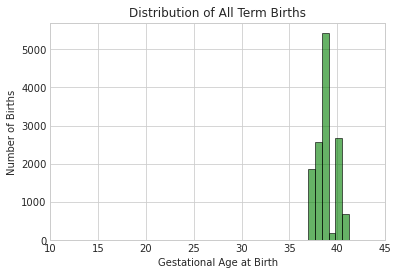

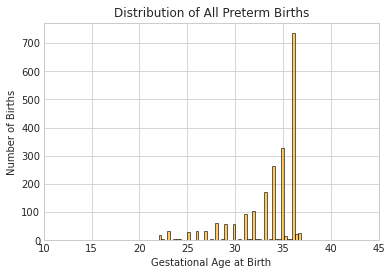

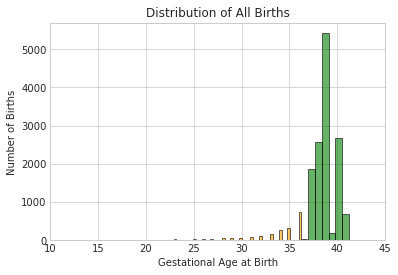

In [19]:
import matplotlib.pyplot as plt

# All Term Births
plt.style.use("seaborn-whitegrid")
term_cases = final_birth_data[final_birth_data['birth_class'] == 'Term']
plt.hist(term_cases['gestational_age_at_birth'], bins=10, alpha=0.6, color='green', edgecolor='black', label='All Term')
plt.xlabel('Gestational Age at Birth')
plt.ylabel('Number of Births')
plt.title('Distribution of All Term Births')
plt.xlim(10, 45) 
plt.show()


# All Preterm Births
non_term_cases = final_birth_data[final_birth_data['birth_class'] != 'Term']
plt.style.use("seaborn-whitegrid")
plt.hist(non_term_cases['gestational_age_at_birth'], bins=50, alpha=0.6, color='orange', edgecolor='black', label='All Preterm')
plt.xlabel('Gestational Age at Birth')
plt.ylabel('Number of Births')
plt.title('Distribution of All Preterm Births')
plt.xlim(10, 45) 
plt.show()


#All Births
plt.style.use("seaborn-whitegrid")
plt.hist(term_cases['gestational_age_at_birth'], bins=10, alpha=0.6, color='green', edgecolor='black', label='All Term')
plt.hist(non_term_cases['gestational_age_at_birth'], bins=50, alpha=0.6, color='orange', edgecolor='black', label='All Preterm')
plt.xlabel('Gestational Age at Birth')
plt.ylabel('Number of Births')
plt.title('Distribution of All Births')
plt.xlim(10, 45) 
plt.show()


In [20]:
#Don't forget to save your work to your local computer and push to GitHub.
#File -> Download as -> Notebook
#Move file from download folder to local repo clone
#git add filename.ipynb
#git commit -m "put a specific and informative message here of what you worked on"
#git push

# Importing the Data From All of Us

## Importing the Birth data

Note that data from *All of Us* is being imported into *Final_Birth_Concept_Set_for_Import* and cleaned there,
so the import takes some time (about 2 mins)

In [21]:
# As needed (i.e. once)
#!pip install import-ipynb

In [22]:
#import import_ipynb
#from Final_Birth_Concept_Set_for_Import import *

In [23]:
final_birth_data.sample(10)

,person_id,condition_start_date,birth_class,gestational_age_at_birth,birth_order
7855,2206384,2019-08-22,Preterm,36.000000,1
14931,8497262,2020-11-07,Term,37.000000,1
2970,1418228,2020-01-06,Term,37.000000,1
6537,1956474,2020-08-04,Term,40.000000,1
1163,1166151,2020-07-20,Term,40.000000,2
4359,1630582,2018-08-30,Term,37.000000,1
8811,2470835,2018-10-25,Term,37.000000,2
3852,1557310,2019-01-21,Term,39.857143,1
11618,3228157,2016-01-09,Term,38.571429,1
11657,3240039,2018-02-16,Term,39.000000,1


## Importing DOB Data

In [24]:
import pandas
import os

# This query represents dataset "Birth_Diabetes_Test" for domain "person" and was generated for All of Us Controlled Tier Dataset v7
dataset_24817314_person_sql = """
    SELECT
        person.person_id,
        person.birth_datetime as date_of_birth 
    FROM
        `""" + os.environ["WORKSPACE_CDR"] + """.person` person   
    WHERE
        person.PERSON_ID IN (
            SELECT
                distinct person_id  
            FROM
                `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` cb_search_person  
            WHERE
                cb_search_person.person_id IN (
                    SELECT
                        criteria.person_id 
                    FROM
                        (SELECT
                            DISTINCT person_id,
                            entry_date,
                            concept_id 
                        FROM
                            `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_all_events` 
                        WHERE
                            (
                                concept_id IN (
                                    SELECT
                                        DISTINCT c.concept_id 
                                    FROM
                                        `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` c 
                                    JOIN
                                        (
                                            select
                                                cast(cr.id as string) as id 
                                            FROM
                                                `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` cr 
                                            WHERE
                                                concept_id IN (36712702, 45757176, 4014295) 
                                                AND full_text LIKE '%_rank1]%'
                                        ) a 
                                            ON (
                                                c.path LIKE CONCAT('%.',
                                            a.id,
                                            '.%') 
                                            OR c.path LIKE CONCAT('%.',
                                            a.id) 
                                            OR c.path LIKE CONCAT(a.id,
                                            '.%') 
                                            OR c.path = a.id) 
                                        WHERE
                                            is_standard = 1 
                                            AND is_selectable = 1
                                        ) 
                                        AND is_standard = 1 
                                )
                            ) criteria 
                        ) 
                        AND cb_search_person.person_id IN (
                            SELECT
                                criteria.person_id 
                            FROM
                                (SELECT
                                    DISTINCT person_id,
                                    entry_date,
                                    concept_id 
                                FROM
                                    `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_all_events` 
                                WHERE
                                    (
                                        concept_id IN (903124) 
                                        AND is_standard = 0 
                                    )) criteria ) 
                        )"""

dataset_24817314_person_df = pandas.read_gbq(
    dataset_24817314_person_sql,
    dialect="standard",
    use_bqstorage_api=("BIGQUERY_STORAGE_API_ENABLED" in os.environ),
    progress_bar_type="tqdm_notebook")

dataset_24817314_person_df.head(5)

Downloading:   0%|          | 0/16016 [00:00<?, ?rows/s]

,person_id,date_of_birth
0,4721252,1987-06-15 00:00:00+00:00
1,1419254,2001-06-15 00:00:00+00:00
2,1192363,1971-06-15 00:00:00+00:00
3,1446224,1992-06-15 00:00:00+00:00
4,2764524,1979-06-15 00:00:00+00:00


## Importing the BMI Data

In [25]:
import pandas
import os

# This query represents dataset "Health Predictors (BMI, Smoking, Drinking)" for domain "measurement" and was generated for All of Us Controlled Tier Dataset v7
dataset_38394017_measurement_sql = """
    SELECT
        measurement.person_id,
        measurement.measurement_concept_id,
        m_standard_concept.concept_name as standard_concept_name,
        m_standard_concept.concept_code as standard_concept_code,
        m_standard_concept.vocabulary_id as standard_vocabulary,
        measurement.measurement_datetime,
        measurement.measurement_type_concept_id,
        m_type.concept_name as measurement_type_concept_name,
        measurement.operator_concept_id,
        m_operator.concept_name as operator_concept_name,
        measurement.value_as_number,
        measurement.value_as_concept_id,
        m_value.concept_name as value_as_concept_name,
        measurement.unit_concept_id,
        m_unit.concept_name as unit_concept_name,
        measurement.range_low,
        measurement.range_high,
        measurement.visit_occurrence_id,
        m_visit.concept_name as visit_occurrence_concept_name,
        measurement.measurement_source_value,
        measurement.measurement_source_concept_id,
        m_source_concept.concept_name as source_concept_name,
        m_source_concept.concept_code as source_concept_code,
        m_source_concept.vocabulary_id as source_vocabulary,
        measurement.unit_source_value,
        measurement.value_source_value 
    FROM
        ( SELECT
            * 
        FROM
            `""" + os.environ["WORKSPACE_CDR"] + """.measurement` measurement 
        WHERE
            (
                measurement_source_concept_id IN  (
                    SELECT
                        DISTINCT c.concept_id 
                    FROM
                        `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` c 
                    JOIN
                        (
                            select
                                cast(cr.id as string) as id 
                            FROM
                                `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` cr 
                            WHERE
                                concept_id IN (
                                    903124
                                ) 
                                AND full_text LIKE '%_rank1]%'
                        ) a 
                            ON (
                                c.path LIKE CONCAT('%.',
                            a.id,
                            '.%') 
                            OR c.path LIKE CONCAT('%.',
                            a.id) 
                            OR c.path LIKE CONCAT(a.id,
                            '.%') 
                            OR c.path = a.id) 
                        WHERE
                            is_standard = 0 
                            AND is_selectable = 1
                        )
                )  
                AND (
                    measurement.PERSON_ID IN (
                        SELECT
                            distinct person_id  
                        FROM
                            `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` cb_search_person  
                        WHERE
                            cb_search_person.person_id IN (
                                SELECT
                                    criteria.person_id 
                                FROM
                                    (SELECT
                                        DISTINCT person_id,
                                        entry_date,
                                        concept_id 
                                    FROM
                                        `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_all_events` 
                                    WHERE
                                        (
                                            concept_id IN (
                                                SELECT
                                                    DISTINCT c.concept_id 
                                                FROM
                                                    `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` c 
                                                JOIN
                                                    (
                                                        select
                                                            cast(cr.id as string) as id 
                                                        FROM
                                                            `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` cr 
                                                        WHERE
                                                            concept_id IN (36712702, 45757176, 4014295) 
                                                            AND full_text LIKE '%_rank1]%'
                                                    ) a 
                                                        ON (
                                                            c.path LIKE CONCAT('%.',
                                                        a.id,
                                                        '.%') 
                                                        OR c.path LIKE CONCAT('%.',
                                                        a.id) 
                                                        OR c.path LIKE CONCAT(a.id,
                                                        '.%') 
                                                        OR c.path = a.id) 
                                                    WHERE
                                                        is_standard = 1 
                                                        AND is_selectable = 1
                                                    ) 
                                                    AND is_standard = 1 
                                            )
                                        ) criteria 
                                    ) 
                                    AND cb_search_person.person_id IN (
                                        SELECT
                                            criteria.person_id 
                                        FROM
                                            (SELECT
                                                DISTINCT person_id,
                                                entry_date,
                                                concept_id 
                                            FROM
                                                `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_all_events` 
                                            WHERE
                                                (
                                                    concept_id IN (903124) 
                                                    AND is_standard = 0 
                                                )) criteria ) 
                                    )
                                )) measurement 
                        LEFT JOIN
                            `""" + os.environ["WORKSPACE_CDR"] + """.concept` m_standard_concept 
                                ON measurement.measurement_concept_id = m_standard_concept.concept_id 
                        LEFT JOIN
                            `""" + os.environ["WORKSPACE_CDR"] + """.concept` m_type 
                                ON measurement.measurement_type_concept_id = m_type.concept_id 
                        LEFT JOIN
                            `""" + os.environ["WORKSPACE_CDR"] + """.concept` m_operator 
                                ON measurement.operator_concept_id = m_operator.concept_id 
                        LEFT JOIN
                            `""" + os.environ["WORKSPACE_CDR"] + """.concept` m_value 
                                ON measurement.value_as_concept_id = m_value.concept_id 
                        LEFT JOIN
                            `""" + os.environ["WORKSPACE_CDR"] + """.concept` m_unit 
                                ON measurement.unit_concept_id = m_unit.concept_id 
                        LEFT JOIn
                            `""" + os.environ["WORKSPACE_CDR"] + """.visit_occurrence` v 
                                ON measurement.visit_occurrence_id = v.visit_occurrence_id 
                        LEFT JOIN
                            `""" + os.environ["WORKSPACE_CDR"] + """.concept` m_visit 
                                ON v.visit_concept_id = m_visit.concept_id 
                        LEFT JOIN
                            `""" + os.environ["WORKSPACE_CDR"] + """.concept` m_source_concept 
                                ON measurement.measurement_source_concept_id = m_source_concept.concept_id"""

dataset_38394017_measurement_df = pandas.read_gbq(
    dataset_38394017_measurement_sql,
    dialect="standard",
    use_bqstorage_api=("BIGQUERY_STORAGE_API_ENABLED" in os.environ),
    progress_bar_type="tqdm_notebook")

dataset_38394017_measurement_df.head(5)

Downloading:   0%|          | 0/16016 [00:00<?, ?rows/s]

,person_id,measurement_concept_id,standard_concept_name,standard_concept_code,standard_vocabulary,measurement_datetime,measurement_type_concept_id,measurement_type_concept_name,operator_concept_id,operator_concept_name,...,range_high,visit_occurrence_id,visit_occurrence_concept_name,measurement_source_value,measurement_source_concept_id,source_concept_name,source_concept_code,source_vocabulary,unit_source_value,value_source_value
0,1754899,3038553,Body mass index (BMI) [Ratio],39156-5,LOINC,2019-09-09 19:05:02+00:00,44818701,From physical examination,0,No matching concept,...,NaN,1000000318284404,Outpatient Visit,bmi,903124,Computed body mass index,bmi,PPI,kg/m2,No matching concept
1,1117052,3038553,Body mass index (BMI) [Ratio],39156-5,LOINC,2019-01-11 19:41:49+00:00,44818701,From physical examination,0,No matching concept,...,NaN,1000000981698529,Outpatient Visit,bmi,903124,Computed body mass index,bmi,PPI,kg/m2,No matching concept
2,2498581,3038553,Body mass index (BMI) [Ratio],39156-5,LOINC,2019-02-21 16:44:15+00:00,44818701,From physical examination,0,No matching concept,...,NaN,1000000960388444,Outpatient Visit,bmi,903124,Computed body mass index,bmi,PPI,kg/m2,No matching concept
3,3172600,3038553,Body mass index (BMI) [Ratio],39156-5,LOINC,2019-08-21 14:13:13+00:00,44818701,From physical examination,0,No matching concept,...,NaN,1000000121879033,Outpatient Visit,bmi,903124,Computed body mass index,bmi,PPI,kg/m2,No matching concept
4,1342312,3038553,Body mass index (BMI) [Ratio],39156-5,LOINC,2020-01-31 21:58:37+00:00,44818701,From physical examination,0,No matching concept,...,NaN,1000000424023093,Outpatient Visit,bmi,903124,Computed body mass index,bmi,PPI,kg/m2,No matching concept


## Importing the Drinking Data

In [26]:
import pandas
import os

# This query represents dataset "Health Predictors (BMI, Smoking, Drinking)" for domain "survey" and was generated for All of Us Controlled Tier Dataset v7
dataset_38394017_survey_sql = """
    SELECT
        answer.person_id,
        answer.survey_datetime,
        answer.survey,
        answer.question_concept_id,
        answer.question,
        answer.answer_concept_id,
        answer.answer,
        answer.survey_version_concept_id,
        answer.survey_version_name  
    FROM
        `""" + os.environ["WORKSPACE_CDR"] + """.ds_survey` answer   
    WHERE
        (
            question_concept_id IN (
                1585636, 1586198, 1586201, 1586207, 1586213
            )
        )  
        AND (
            answer.PERSON_ID IN (
                SELECT
                    distinct person_id  
                FROM
                    `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` cb_search_person  
                WHERE
                    cb_search_person.person_id IN (
                        SELECT
                            criteria.person_id 
                        FROM
                            (SELECT
                                DISTINCT person_id,
                                entry_date,
                                concept_id 
                            FROM
                                `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_all_events` 
                            WHERE
                                (
                                    concept_id IN (
                                        SELECT
                                            DISTINCT c.concept_id 
                                        FROM
                                            `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` c 
                                        JOIN
                                            (
                                                select
                                                    cast(cr.id as string) as id 
                                                FROM
                                                    `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` cr 
                                                WHERE
                                                    concept_id IN (36712702, 45757176, 4014295) 
                                                    AND full_text LIKE '%_rank1]%'
                                            ) a 
                                                ON (
                                                    c.path LIKE CONCAT('%.',
                                                a.id,
                                                '.%') 
                                                OR c.path LIKE CONCAT('%.',
                                                a.id) 
                                                OR c.path LIKE CONCAT(a.id,
                                                '.%') 
                                                OR c.path = a.id) 
                                            WHERE
                                                is_standard = 1 
                                                AND is_selectable = 1
                                            ) 
                                            AND is_standard = 1 
                                    )
                                ) criteria 
                            ) 
                            AND cb_search_person.person_id IN (
                                SELECT
                                    criteria.person_id 
                                FROM
                                    (SELECT
                                        DISTINCT person_id,
                                        entry_date,
                                        concept_id 
                                    FROM
                                        `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_all_events` 
                                    WHERE
                                        (
                                            concept_id IN (903124) 
                                            AND is_standard = 0 
                                        )) criteria ) 
                            )
                        )"""

dataset_38394017_survey_df = pandas.read_gbq(
    dataset_38394017_survey_sql,
    dialect="standard",
    use_bqstorage_api=("BIGQUERY_STORAGE_API_ENABLED" in os.environ),
    progress_bar_type="tqdm_notebook")

dataset_38394017_survey_df.head(5)

Downloading:   0%|          | 0/73363 [00:00<?, ?rows/s]

,person_id,survey_datetime,survey,question_concept_id,question,answer_concept_id,answer,survey_version_concept_id,survey_version_name
0,1698477,2019-04-23 19:08:29+00:00,Lifestyle,1586198,Alcohol: Alcohol Participant,903096,PMI: Skip,<NA>,None
1,2625731,2017-09-29 15:22:08+00:00,Lifestyle,1586198,Alcohol: Alcohol Participant,903096,PMI: Skip,<NA>,None
2,1040294,2019-02-20 18:05:30+00:00,Lifestyle,1586198,Alcohol: Alcohol Participant,1586200,Alcohol Participant: No,<NA>,None
3,6897122,2021-12-16 17:14:28+00:00,Lifestyle,1586198,Alcohol: Alcohol Participant,1586200,Alcohol Participant: No,<NA>,None
4,1290271,2020-01-31 19:59:08+00:00,Lifestyle,1586198,Alcohol: Alcohol Participant,1586200,Alcohol Participant: No,<NA>,None


## Importing the Smoking Data

In [27]:
import pandas
import os

# This query represents dataset "Health Predictors (BMI, Smoking, Drinking)" for domain "observation" and was generated for All of Us Controlled Tier Dataset v7
dataset_38394017_observation_sql = """
    SELECT
        observation.person_id,
        observation.observation_concept_id,
        o_standard_concept.concept_name as standard_concept_name,
        o_standard_concept.concept_code as standard_concept_code,
        o_standard_concept.vocabulary_id as standard_vocabulary,
        observation.observation_datetime,
        observation.observation_type_concept_id,
        o_type.concept_name as observation_type_concept_name,
        observation.value_as_number,
        observation.value_as_string,
        observation.value_as_concept_id,
        o_value.concept_name as value_as_concept_name,
        observation.qualifier_concept_id,
        o_qualifier.concept_name as qualifier_concept_name,
        observation.unit_concept_id,
        o_unit.concept_name as unit_concept_name,
        observation.visit_occurrence_id,
        o_visit.concept_name as visit_occurrence_concept_name,
        observation.observation_source_value,
        observation.observation_source_concept_id,
        o_source_concept.concept_name as source_concept_name,
        o_source_concept.concept_code as source_concept_code,
        o_source_concept.vocabulary_id as source_vocabulary,
        observation.unit_source_value,
        observation.qualifier_source_value,
        observation.value_source_concept_id,
        observation.value_source_value,
        observation.questionnaire_response_id 
    FROM
        ( SELECT
            * 
        FROM
            `""" + os.environ["WORKSPACE_CDR"] + """.observation` observation 
        WHERE
            (
                observation_concept_id IN (
                    4275495, 4276526, 43054909
                ) 
                OR  observation_source_concept_id IN (
                    1585636, 1586198, 1586201, 1586207, 1586213
                )
            )  
            AND (
                observation.PERSON_ID IN (
                    SELECT
                        distinct person_id  
                    FROM
                        `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` cb_search_person  
                    WHERE
                        cb_search_person.person_id IN (
                            SELECT
                                criteria.person_id 
                            FROM
                                (SELECT
                                    DISTINCT person_id,
                                    entry_date,
                                    concept_id 
                                FROM
                                    `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_all_events` 
                                WHERE
                                    (
                                        concept_id IN (
                                            SELECT
                                                DISTINCT c.concept_id 
                                            FROM
                                                `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` c 
                                            JOIN
                                                (
                                                    select
                                                        cast(cr.id as string) as id 
                                                    FROM
                                                        `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` cr 
                                                    WHERE
                                                        concept_id IN (36712702, 45757176, 4014295) 
                                                        AND full_text LIKE '%_rank1]%'
                                                ) a 
                                                    ON (
                                                        c.path LIKE CONCAT('%.',
                                                    a.id,
                                                    '.%') 
                                                    OR c.path LIKE CONCAT('%.',
                                                    a.id) 
                                                    OR c.path LIKE CONCAT(a.id,
                                                    '.%') 
                                                    OR c.path = a.id) 
                                                WHERE
                                                    is_standard = 1 
                                                    AND is_selectable = 1
                                                ) 
                                                AND is_standard = 1 
                                        )
                                    ) criteria 
                                ) 
                                AND cb_search_person.person_id IN (
                                    SELECT
                                        criteria.person_id 
                                    FROM
                                        (SELECT
                                            DISTINCT person_id,
                                            entry_date,
                                            concept_id 
                                        FROM
                                            `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_all_events` 
                                        WHERE
                                            (
                                                concept_id IN (903124) 
                                                AND is_standard = 0 
                                            )) criteria ) 
                                )
                            )) observation 
                    LEFT JOIN
                        `""" + os.environ["WORKSPACE_CDR"] + """.concept` o_standard_concept 
                            ON observation.observation_concept_id = o_standard_concept.concept_id 
                    LEFT JOIN
                        `""" + os.environ["WORKSPACE_CDR"] + """.concept` o_type 
                            ON observation.observation_type_concept_id = o_type.concept_id 
                    LEFT JOIN
                        `""" + os.environ["WORKSPACE_CDR"] + """.concept` o_value 
                            ON observation.value_as_concept_id = o_value.concept_id 
                    LEFT JOIN
                        `""" + os.environ["WORKSPACE_CDR"] + """.concept` o_qualifier 
                            ON observation.qualifier_concept_id = o_qualifier.concept_id 
                    LEFT JOIN
                        `""" + os.environ["WORKSPACE_CDR"] + """.concept` o_unit 
                            ON observation.unit_concept_id = o_unit.concept_id 
                    LEFT JOIN
                        `""" + os.environ["WORKSPACE_CDR"] + """.visit_occurrence` v 
                            ON observation.visit_occurrence_id = v.visit_occurrence_id 
                    LEFT JOIN
                        `""" + os.environ["WORKSPACE_CDR"] + """.concept` o_visit 
                            ON v.visit_concept_id = o_visit.concept_id 
                    LEFT JOIN
                        `""" + os.environ["WORKSPACE_CDR"] + """.concept` o_source_concept 
                            ON observation.observation_source_concept_id = o_source_concept.concept_id"""

dataset_38394017_observation_df = pandas.read_gbq(
    dataset_38394017_observation_sql,
    dialect="standard",
    use_bqstorage_api=("BIGQUERY_STORAGE_API_ENABLED" in os.environ),
    progress_bar_type="tqdm_notebook")

dataset_38394017_observation_df.head(5)

Downloading:   0%|          | 0/263788 [00:00<?, ?rows/s]

,person_id,observation_concept_id,standard_concept_name,standard_concept_code,standard_vocabulary,observation_datetime,observation_type_concept_id,observation_type_concept_name,value_as_number,value_as_string,...,observation_source_value,observation_source_concept_id,source_concept_name,source_concept_code,source_vocabulary,unit_source_value,qualifier_source_value,value_source_concept_id,value_source_value,questionnaire_response_id
0,1354929,4275495,Tobacco smoking behavior - finding,365981007,SNOMED,2020-12-03 05:00:00+00:00,32865,Patient self-report,NaN,8517006,...,None,<NA>,None,None,None,None,None,<NA>,None,<NA>
1,2852866,4275495,Tobacco smoking behavior - finding,365981007,SNOMED,2021-11-09 05:00:00+00:00,32865,Patient self-report,NaN,266919005,...,None,<NA>,None,None,None,None,None,<NA>,None,<NA>
2,2979772,4275495,Tobacco smoking behavior - finding,365981007,SNOMED,2021-03-22 04:00:00+00:00,32865,Patient self-report,NaN,428041000124106,...,None,<NA>,None,None,None,None,None,<NA>,None,<NA>
3,2625731,4275495,Tobacco smoking behavior - finding,365981007,SNOMED,2021-06-07 04:00:00+00:00,32865,Patient self-report,NaN,266919005,...,None,<NA>,None,None,None,None,None,<NA>,None,<NA>
4,1134433,4275495,Tobacco smoking behavior - finding,365981007,SNOMED,2020-04-24 04:00:00+00:00,32865,Patient self-report,NaN,266919005,...,None,<NA>,None,None,None,None,None,<NA>,None,<NA>


## Importing the Diabetes Data

In [28]:
import pandas
import os

# This query represents dataset "Birth_Diabetes_Test" for domain "condition" and was generated for All of Us Controlled Tier Dataset v7
dataset_55961866_condition_sql = """
    SELECT
        c_occurrence.person_id,
        c_occurrence.condition_concept_id,
        c_standard_concept.concept_name as standard_concept_name,
        c_standard_concept.concept_code as standard_concept_code,
        c_standard_concept.vocabulary_id as standard_vocabulary,
        c_occurrence.condition_start_datetime,
        c_occurrence.condition_end_datetime,
        c_occurrence.condition_type_concept_id,
        c_type.concept_name as condition_type_concept_name,
        c_occurrence.stop_reason,
        c_occurrence.visit_occurrence_id,
        visit.concept_name as visit_occurrence_concept_name,
        c_occurrence.condition_source_value,
        c_occurrence.condition_source_concept_id,
        c_source_concept.concept_name as source_concept_name,
        c_source_concept.concept_code as source_concept_code,
        c_source_concept.vocabulary_id as source_vocabulary,
        c_occurrence.condition_status_source_value,
        c_occurrence.condition_status_concept_id,
        c_status.concept_name as condition_status_concept_name 
    FROM
        ( SELECT
            * 
        FROM
            `""" + os.environ["WORKSPACE_CDR"] + """.condition_occurrence` c_occurrence 
        WHERE
            (
                condition_concept_id IN  (
                    SELECT
                        DISTINCT c.concept_id 
                    FROM
                        `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` c 
                    JOIN
                        (
                            select
                                cast(cr.id as string) as id 
                            FROM
                                `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` cr 
                            WHERE
                                concept_id IN (
                                    201820, 201826, 37016349, 37311673
                                ) 
                                AND full_text LIKE '%_rank1]%'
                        ) a 
                            ON (
                                c.path LIKE CONCAT('%.',
                            a.id,
                            '.%') 
                            OR c.path LIKE CONCAT('%.',
                            a.id) 
                            OR c.path LIKE CONCAT(a.id,
                            '.%') 
                            OR c.path = a.id) 
                        WHERE
                            is_standard = 1 
                            AND is_selectable = 1
                        )
                )  
                AND (
                    c_occurrence.PERSON_ID IN (
                        SELECT
                            distinct person_id  
                        FROM
                            `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` cb_search_person  
                        WHERE
                            cb_search_person.person_id IN (
                                SELECT
                                    criteria.person_id 
                                FROM
                                    (SELECT
                                        DISTINCT person_id,
                                        entry_date,
                                        concept_id 
                                    FROM
                                        `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_all_events` 
                                    WHERE
                                        (
                                            concept_id IN (
                                                SELECT
                                                    DISTINCT c.concept_id 
                                                FROM
                                                    `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` c 
                                                JOIN
                                                    (
                                                        select
                                                            cast(cr.id as string) as id 
                                                        FROM
                                                            `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` cr 
                                                        WHERE
                                                            concept_id IN (36712702, 45757176, 4014295) 
                                                            AND full_text LIKE '%_rank1]%'
                                                    ) a 
                                                        ON (
                                                            c.path LIKE CONCAT('%.',
                                                        a.id,
                                                        '.%') 
                                                        OR c.path LIKE CONCAT('%.',
                                                        a.id) 
                                                        OR c.path LIKE CONCAT(a.id,
                                                        '.%') 
                                                        OR c.path = a.id) 
                                                    WHERE
                                                        is_standard = 1 
                                                        AND is_selectable = 1
                                                    ) 
                                                    AND is_standard = 1 
                                            )
                                        ) criteria 
                                    ) 
                                    AND cb_search_person.person_id IN (
                                        SELECT
                                            criteria.person_id 
                                        FROM
                                            (SELECT
                                                DISTINCT person_id,
                                                entry_date,
                                                concept_id 
                                            FROM
                                                `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_all_events` 
                                            WHERE
                                                (
                                                    concept_id IN (903124) 
                                                    AND is_standard = 0 
                                                )) criteria ) 
                                    )
                                )) c_occurrence 
                        LEFT JOIN
                            `""" + os.environ["WORKSPACE_CDR"] + """.concept` c_standard_concept 
                                ON c_occurrence.condition_concept_id = c_standard_concept.concept_id 
                        LEFT JOIN
                            `""" + os.environ["WORKSPACE_CDR"] + """.concept` c_type 
                                ON c_occurrence.condition_type_concept_id = c_type.concept_id 
                        LEFT JOIN
                            `""" + os.environ["WORKSPACE_CDR"] + """.visit_occurrence` v 
                                ON c_occurrence.visit_occurrence_id = v.visit_occurrence_id 
                        LEFT JOIN
                            `""" + os.environ["WORKSPACE_CDR"] + """.concept` visit 
                                ON v.visit_concept_id = visit.concept_id 
                        LEFT JOIN
                            `""" + os.environ["WORKSPACE_CDR"] + """.concept` c_source_concept 
                                ON c_occurrence.condition_source_concept_id = c_source_concept.concept_id 
                        LEFT JOIN
                            `""" + os.environ["WORKSPACE_CDR"] + """.concept` c_status 
                                ON c_occurrence.condition_status_concept_id = c_status.concept_id"""

dataset_55961866_condition_df = pandas.read_gbq(
    dataset_55961866_condition_sql,
    dialect="standard",
    use_bqstorage_api=("BIGQUERY_STORAGE_API_ENABLED" in os.environ),
    progress_bar_type="tqdm_notebook")

dataset_55961866_condition_df.head(10)

Downloading:   0%|          | 0/109418 [00:00<?, ?rows/s]

,person_id,condition_concept_id,standard_concept_name,standard_concept_code,standard_vocabulary,condition_start_datetime,condition_end_datetime,condition_type_concept_id,condition_type_concept_name,stop_reason,visit_occurrence_id,visit_occurrence_concept_name,condition_source_value,condition_source_concept_id,source_concept_name,source_concept_code,source_vocabulary,condition_status_source_value,condition_status_concept_id,condition_status_concept_name
0,9561926,4058243,"Diabetes mellitus during pregnancy, childbirth...",199223000,SNOMED,2019-10-25 00:00:00+00:00,NaT,44786627,Primary Condition,None,44000000001291008,Outpatient Visit,199223000,4058243,"Diabetes mellitus during pregnancy, childbirth...",199223000,SNOMED,None,<NA>,None
1,2402957,201254,Type 1 diabetes mellitus,46635009,SNOMED,2008-10-06 04:00:00+00:00,NaT,32821,EHR billing record,None,33000000015063752,Outpatient Visit,250.93,44819504,"Diabetes with unspecified complication, type I...",250.93,ICD9CM,None,<NA>,None
2,2494456,195771,Secondary diabetes mellitus,8801005,SNOMED,2018-07-27 09:28:00+00:00,2018-07-27 11:59:59+00:00,44786627,Primary Condition,None,27000000008243728,Outpatient Visit,E08.59,45581343,Diabetes mellitus due to underlying condition ...,E08.59,ICD10CM,None,<NA>,None
3,2198153,201254,Type 1 diabetes mellitus,46635009,SNOMED,2018-12-26 00:00:00+00:00,NaT,0,No matching concept,None,44000000001792656,Inpatient Visit,46635009,201254,Type 1 diabetes mellitus,46635009,SNOMED,None,<NA>,None
4,2198153,201254,Type 1 diabetes mellitus,46635009,SNOMED,2021-08-26 00:00:00+00:00,NaT,0,No matching concept,None,44000000001561784,Inpatient Visit,46635009,201254,Type 1 diabetes mellitus,46635009,SNOMED,None,<NA>,None
5,2198153,201254,Type 1 diabetes mellitus,46635009,SNOMED,2021-09-24 00:00:00+00:00,NaT,44786627,Primary Condition,None,44000000001269064,Outpatient Visit,46635009,201254,Type 1 diabetes mellitus,46635009,SNOMED,None,<NA>,None
6,4605005,45757124,Gestational diabetes mellitus in childbirth,10753491000119101,SNOMED,2021-08-22 06:00:00+00:00,NaT,32810,Claim,None,42000000185390352,Inpatient Visit,O24.425,37200978,"Gestational diabetes mellitus in childbirth, c...",O24.425,ICD10CM,None,<NA>,None
7,1705749,201254,Type 1 diabetes mellitus,46635009,SNOMED,2019-06-12 00:00:00+00:00,2019-06-12 11:59:59+00:00,44786627,Primary Condition,None,27000000013957300,Inpatient Visit,E10.8,35206878,Type 1 diabetes mellitus with unspecified comp...,E10.8,ICD10CM,None,<NA>,None
8,2003289,201254,Type 1 diabetes mellitus,46635009,SNOMED,2019-06-11 14:54:28.653000+00:00,NaT,32840,EHR problem list,None,33000000006307744,Outpatient Visit,E10.8,35206878,Type 1 diabetes mellitus with unspecified comp...,E10.8,ICD10CM,None,<NA>,None
9,2375170,201254,Type 1 diabetes mellitus,46635009,SNOMED,2016-04-11 13:00:00+00:00,2016-04-11 11:59:59+00:00,44786629,Secondary Condition,None,27000000002713124,Outpatient Visit,E10.8,35206878,Type 1 diabetes mellitus with unspecified comp...,E10.8,ICD10CM,None,<NA>,None


## Importing the Depression & Anxiety Data

In [29]:
import pandas
import os

# This query represents dataset "Birth_Depression_Anxiety" for domain "condition" and was generated for All of Us Controlled Tier Dataset v7
dataset_79875266_condition_sql = """
    SELECT
        c_occurrence.person_id,
        c_occurrence.condition_concept_id,
        c_standard_concept.concept_name as standard_concept_name,
        c_standard_concept.concept_code as standard_concept_code,
        c_standard_concept.vocabulary_id as standard_vocabulary,
        c_occurrence.condition_start_datetime,
        c_occurrence.condition_end_datetime,
        c_occurrence.condition_type_concept_id,
        c_type.concept_name as condition_type_concept_name,
        c_occurrence.stop_reason,
        c_occurrence.visit_occurrence_id,
        visit.concept_name as visit_occurrence_concept_name,
        c_occurrence.condition_source_value,
        c_occurrence.condition_source_concept_id,
        c_source_concept.concept_name as source_concept_name,
        c_source_concept.concept_code as source_concept_code,
        c_source_concept.vocabulary_id as source_vocabulary,
        c_occurrence.condition_status_source_value,
        c_occurrence.condition_status_concept_id,
        c_status.concept_name as condition_status_concept_name 
    FROM
        ( SELECT
            * 
        FROM
            `""" + os.environ["WORKSPACE_CDR"] + """.condition_occurrence` c_occurrence 
        WHERE
            (
                condition_concept_id IN  (
                    SELECT
                        DISTINCT c.concept_id 
                    FROM
                        `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` c 
                    JOIN
                        (
                            select
                                cast(cr.id as string) as id 
                            FROM
                                `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` cr 
                            WHERE
                                concept_id IN (
                                    440383, 442077
                                ) 
                                AND full_text LIKE '%_rank1]%'
                        ) a 
                            ON (
                                c.path LIKE CONCAT('%.',
                            a.id,
                            '.%') 
                            OR c.path LIKE CONCAT('%.',
                            a.id) 
                            OR c.path LIKE CONCAT(a.id,
                            '.%') 
                            OR c.path = a.id) 
                        WHERE
                            is_standard = 1 
                            AND is_selectable = 1
                        )
                )  
                AND (
                    c_occurrence.PERSON_ID IN (
                        SELECT
                            distinct person_id  
                        FROM
                            `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` cb_search_person  
                        WHERE
                            cb_search_person.person_id IN (
                                SELECT
                                    criteria.person_id 
                                FROM
                                    (SELECT
                                        DISTINCT person_id,
                                        entry_date,
                                        concept_id 
                                    FROM
                                        `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_all_events` 
                                    WHERE
                                        (
                                            concept_id IN (
                                                SELECT
                                                    DISTINCT c.concept_id 
                                                FROM
                                                    `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` c 
                                                JOIN
                                                    (
                                                        select
                                                            cast(cr.id as string) as id 
                                                        FROM
                                                            `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` cr 
                                                        WHERE
                                                            concept_id IN (36712702, 45757176, 4014295) 
                                                            AND full_text LIKE '%_rank1]%'
                                                    ) a 
                                                        ON (
                                                            c.path LIKE CONCAT('%.',
                                                        a.id,
                                                        '.%') 
                                                        OR c.path LIKE CONCAT('%.',
                                                        a.id) 
                                                        OR c.path LIKE CONCAT(a.id,
                                                        '.%') 
                                                        OR c.path = a.id) 
                                                    WHERE
                                                        is_standard = 1 
                                                        AND is_selectable = 1
                                                    ) 
                                                    AND is_standard = 1 
                                            )
                                        ) criteria 
                                    ) 
                                    AND cb_search_person.person_id IN (
                                        SELECT
                                            criteria.person_id 
                                        FROM
                                            (SELECT
                                                DISTINCT person_id,
                                                entry_date,
                                                concept_id 
                                            FROM
                                                `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_all_events` 
                                            WHERE
                                                (
                                                    concept_id IN (903124) 
                                                    AND is_standard = 0 
                                                )) criteria ) 
                                    )
                                )) c_occurrence 
                        LEFT JOIN
                            `""" + os.environ["WORKSPACE_CDR"] + """.concept` c_standard_concept 
                                ON c_occurrence.condition_concept_id = c_standard_concept.concept_id 
                        LEFT JOIN
                            `""" + os.environ["WORKSPACE_CDR"] + """.concept` c_type 
                                ON c_occurrence.condition_type_concept_id = c_type.concept_id 
                        LEFT JOIN
                            `""" + os.environ["WORKSPACE_CDR"] + """.visit_occurrence` v 
                                ON c_occurrence.visit_occurrence_id = v.visit_occurrence_id 
                        LEFT JOIN
                            `""" + os.environ["WORKSPACE_CDR"] + """.concept` visit 
                                ON v.visit_concept_id = visit.concept_id 
                        LEFT JOIN
                            `""" + os.environ["WORKSPACE_CDR"] + """.concept` c_source_concept 
                                ON c_occurrence.condition_source_concept_id = c_source_concept.concept_id 
                        LEFT JOIN
                            `""" + os.environ["WORKSPACE_CDR"] + """.concept` c_status 
                                ON c_occurrence.condition_status_concept_id = c_status.concept_id"""

dataset_79875266_condition_df = pandas.read_gbq(
    dataset_79875266_condition_sql,
    dialect="standard",
    use_bqstorage_api=("BIGQUERY_STORAGE_API_ENABLED" in os.environ),
    progress_bar_type="tqdm_notebook")

dataset_79875266_condition_df.head(10)

Downloading:   0%|          | 0/240666 [00:00<?, ?rows/s]

,person_id,condition_concept_id,standard_concept_name,standard_concept_code,standard_vocabulary,condition_start_datetime,condition_end_datetime,condition_type_concept_id,condition_type_concept_name,stop_reason,visit_occurrence_id,visit_occurrence_concept_name,condition_source_value,condition_source_concept_id,source_concept_name,source_concept_code,source_vocabulary,condition_status_source_value,condition_status_concept_id,condition_status_concept_name
0,1030737,437528,"Bipolar affective disorder, currently depresse...",191630001,SNOMED,2021-10-29 16:04:00+00:00,2021-10-29 11:59:59+00:00,44786629,Secondary Condition,None,27000000005357744,Outpatient Visit,F31.32,45538062,"Bipolar disorder, current episode depressed, m...",F31.32,ICD10CM,None,<NA>,None
1,5286775,4025677,Single episode of major depression in full rem...,19527009,SNOMED,2020-10-12 06:00:00+00:00,NaT,32821,EHR billing record,None,42000000079529656,Outpatient Visit,F32.5,45547704,"Major depressive disorder, single episode, in ...",F32.5,ICD10CM,None,<NA>,None
2,1381043,4025677,Single episode of major depression in full rem...,19527009,SNOMED,2021-02-22 00:00:00+00:00,2021-02-22 11:59:59+00:00,44786627,Primary Condition,None,27000000006653916,Outpatient Visit,F32.5,45547704,"Major depressive disorder, single episode, in ...",F32.5,ICD10CM,None,<NA>,None
3,5286775,4025677,Single episode of major depression in full rem...,19527009,SNOMED,2018-10-02 06:00:00+00:00,NaT,32821,EHR billing record,None,42000000079529424,Outpatient Visit,F32.5,45547704,"Major depressive disorder, single episode, in ...",F32.5,ICD10CM,None,<NA>,None
4,1373223,4025677,Single episode of major depression in full rem...,19527009,SNOMED,2022-05-11 00:00:00+00:00,2022-05-11 11:59:59+00:00,44786629,Secondary Condition,None,27000000003343760,Outpatient Visit,F32.5,45547704,"Major depressive disorder, single episode, in ...",F32.5,ICD10CM,None,<NA>,None
5,5286775,4025677,Single episode of major depression in full rem...,19527009,SNOMED,2019-09-06 06:00:00+00:00,NaT,32821,EHR billing record,None,42000000079529520,Outpatient Visit,F32.5,45547704,"Major depressive disorder, single episode, in ...",F32.5,ICD10CM,None,<NA>,None
6,2931891,4049623,"Moderate major depression, single episode",15639000,SNOMED,2021-12-06 00:00:00+00:00,2021-12-06 11:59:59+00:00,0,No matching concept,None,27000000006970152,Outpatient Visit,F32.1,35207151,"Major depressive disorder, single episode, mod...",F32.1,ICD10CM,None,<NA>,None
7,2931891,4049623,"Moderate major depression, single episode",15639000,SNOMED,2021-02-08 00:00:00+00:00,2021-02-08 11:59:59+00:00,44786629,Secondary Condition,None,27000000001856544,Outpatient Visit,F32.1,35207151,"Major depressive disorder, single episode, mod...",F32.1,ICD10CM,None,<NA>,None
8,1381043,4049623,"Moderate major depression, single episode",15639000,SNOMED,2018-12-27 00:00:00+00:00,2018-12-27 11:59:59+00:00,0,No matching concept,None,27000000004688676,Outpatient Visit,F32.1,35207151,"Major depressive disorder, single episode, mod...",F32.1,ICD10CM,None,<NA>,None
9,6656672,4049623,"Moderate major depression, single episode",15639000,SNOMED,2021-06-15 00:50:00+00:00,2021-06-15 11:59:59+00:00,44786627,Primary Condition,None,27000000012484612,Outpatient Visit,F32.1,35207151,"Major depressive disorder, single episode, mod...",F32.1,ICD10CM,None,<NA>,None


## Importing the Drug Abuse Data

In [30]:
import pandas
import os

# This query represents dataset "Birth_Drug_Abuse" for domain "condition" and was generated for All of Us Controlled Tier Dataset v7
dataset_07549439_condition_sql = """
    SELECT
        c_occurrence.person_id,
        c_occurrence.condition_concept_id,
        c_standard_concept.concept_name as standard_concept_name,
        c_standard_concept.concept_code as standard_concept_code,
        c_standard_concept.vocabulary_id as standard_vocabulary,
        c_occurrence.condition_start_datetime,
        c_occurrence.condition_end_datetime,
        c_occurrence.condition_type_concept_id,
        c_type.concept_name as condition_type_concept_name,
        c_occurrence.stop_reason,
        c_occurrence.visit_occurrence_id,
        visit.concept_name as visit_occurrence_concept_name,
        c_occurrence.condition_source_value,
        c_occurrence.condition_source_concept_id,
        c_source_concept.concept_name as source_concept_name,
        c_source_concept.concept_code as source_concept_code,
        c_source_concept.vocabulary_id as source_vocabulary,
        c_occurrence.condition_status_source_value,
        c_occurrence.condition_status_concept_id,
        c_status.concept_name as condition_status_concept_name 
    FROM
        ( SELECT
            * 
        FROM
            `""" + os.environ["WORKSPACE_CDR"] + """.condition_occurrence` c_occurrence 
        WHERE
            (
                condition_concept_id IN  (
                    SELECT
                        DISTINCT c.concept_id 
                    FROM
                        `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` c 
                    JOIN
                        (
                            select
                                cast(cr.id as string) as id 
                            FROM
                                `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` cr 
                            WHERE
                                concept_id IN (
                                    436954
                                ) 
                                AND full_text LIKE '%_rank1]%'
                        ) a 
                            ON (
                                c.path LIKE CONCAT('%.',
                            a.id,
                            '.%') 
                            OR c.path LIKE CONCAT('%.',
                            a.id) 
                            OR c.path LIKE CONCAT(a.id,
                            '.%') 
                            OR c.path = a.id) 
                        WHERE
                            is_standard = 1 
                            AND is_selectable = 1
                        )
                )  
                AND (
                    c_occurrence.PERSON_ID IN (
                        SELECT
                            distinct person_id  
                        FROM
                            `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` cb_search_person  
                        WHERE
                            cb_search_person.person_id IN (
                                SELECT
                                    criteria.person_id 
                                FROM
                                    (SELECT
                                        DISTINCT person_id,
                                        entry_date,
                                        concept_id 
                                    FROM
                                        `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_all_events` 
                                    WHERE
                                        (
                                            concept_id IN (
                                                SELECT
                                                    DISTINCT c.concept_id 
                                                FROM
                                                    `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` c 
                                                JOIN
                                                    (
                                                        select
                                                            cast(cr.id as string) as id 
                                                        FROM
                                                            `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` cr 
                                                        WHERE
                                                            concept_id IN (36712702, 45757176, 4014295) 
                                                            AND full_text LIKE '%_rank1]%'
                                                    ) a 
                                                        ON (
                                                            c.path LIKE CONCAT('%.',
                                                        a.id,
                                                        '.%') 
                                                        OR c.path LIKE CONCAT('%.',
                                                        a.id) 
                                                        OR c.path LIKE CONCAT(a.id,
                                                        '.%') 
                                                        OR c.path = a.id) 
                                                    WHERE
                                                        is_standard = 1 
                                                        AND is_selectable = 1
                                                    ) 
                                                    AND is_standard = 1 
                                            )
                                        ) criteria 
                                    ) 
                                    AND cb_search_person.person_id IN (
                                        SELECT
                                            criteria.person_id 
                                        FROM
                                            (SELECT
                                                DISTINCT person_id,
                                                entry_date,
                                                concept_id 
                                            FROM
                                                `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_all_events` 
                                            WHERE
                                                (
                                                    concept_id IN (903124) 
                                                    AND is_standard = 0 
                                                )) criteria ) 
                                    )
                                )) c_occurrence 
                        LEFT JOIN
                            `""" + os.environ["WORKSPACE_CDR"] + """.concept` c_standard_concept 
                                ON c_occurrence.condition_concept_id = c_standard_concept.concept_id 
                        LEFT JOIN
                            `""" + os.environ["WORKSPACE_CDR"] + """.concept` c_type 
                                ON c_occurrence.condition_type_concept_id = c_type.concept_id 
                        LEFT JOIN
                            `""" + os.environ["WORKSPACE_CDR"] + """.visit_occurrence` v 
                                ON c_occurrence.visit_occurrence_id = v.visit_occurrence_id 
                        LEFT JOIN
                            `""" + os.environ["WORKSPACE_CDR"] + """.concept` visit 
                                ON v.visit_concept_id = visit.concept_id 
                        LEFT JOIN
                            `""" + os.environ["WORKSPACE_CDR"] + """.concept` c_source_concept 
                                ON c_occurrence.condition_source_concept_id = c_source_concept.concept_id 
                        LEFT JOIN
                            `""" + os.environ["WORKSPACE_CDR"] + """.concept` c_status 
                                ON c_occurrence.condition_status_concept_id = c_status.concept_id"""

dataset_07549439_condition_df = pandas.read_gbq(
    dataset_07549439_condition_sql,
    dialect="standard",
    use_bqstorage_api=("BIGQUERY_STORAGE_API_ENABLED" in os.environ),
    progress_bar_type="tqdm_notebook")

dataset_07549439_condition_df.head(5)

Downloading:   0%|          | 0/3526 [00:00<?, ?rows/s]

,person_id,condition_concept_id,standard_concept_name,standard_concept_code,standard_vocabulary,condition_start_datetime,condition_end_datetime,condition_type_concept_id,condition_type_concept_name,stop_reason,visit_occurrence_id,visit_occurrence_concept_name,condition_source_value,condition_source_concept_id,source_concept_name,source_concept_code,source_vocabulary,condition_status_source_value,condition_status_concept_id,condition_status_concept_name
0,3269820,436954,Drug abuse,26416006,SNOMED,2014-07-23 06:00:00+00:00,NaT,32821,EHR billing record,None,42000000091522048,Outpatient Visit,305.90,44831107,"Other, mixed, or unspecified drug abuse, unspe...",305.90,ICD9CM,None,<NA>,None
1,1672458,435231,Nondependent cannabis abuse in remission,191895007,SNOMED,2019-04-01 06:00:00+00:00,NaT,32821,EHR billing record,None,42000000175830696,Outpatient Visit,F12.11,1326499,"Cannabis abuse, in remission",F12.11,ICD10CM,None,<NA>,None
2,1052938,436954,Drug abuse,26416006,SNOMED,2016-04-12 00:00:00+00:00,2016-04-12 11:59:59+00:00,44786629,Secondary Condition,None,27000000001763728,Outpatient Visit,305.90,44831107,"Other, mixed, or unspecified drug abuse, unspe...",305.90,ICD9CM,None,<NA>,None
3,3026032,436954,Drug abuse,26416006,SNOMED,2017-07-12 00:00:00+00:00,NaT,44786629,Secondary Condition,None,9000000005910184,Office Visit,305.90,44831107,"Other, mixed, or unspecified drug abuse, unspe...",305.90,ICD9CM,None,<NA>,None
4,1773386,436954,Drug abuse,26416006,SNOMED,2005-05-20 06:00:00+00:00,NaT,32821,EHR billing record,None,42000000053894704,Inpatient Visit,305.90,44831107,"Other, mixed, or unspecified drug abuse, unspe...",305.90,ICD9CM,None,<NA>,None


# Combining each data frame into a single data frame

## Importing needed packages

In [31]:
import pandas as pd

## Renaming individual data frames and dropping columns we don't need

In [32]:
# condition_df

condition_df = final_birth_data



# dob_df (date of birth)

dob_df = dataset_24817314_person_df



# bmi_df

bmi_df_drop_columns = dataset_38394017_measurement_df.columns.tolist()


bmi_df_drop_columns.remove('person_id')
bmi_df_drop_columns.remove('value_as_number')
# bmi_df_drop_columns.remove('range_low') - upon investigation, not helpful
# bmi_df_drop_columns.remove('range_high') - upon investigation, not helpful
# bmi_df_drop_columns.remove('unit_source_value') - confirmed all observations using same units (kg/m^2)

bmi_df = dataset_38394017_measurement_df.drop(columns=bmi_df_drop_columns).rename(columns={'value_as_number':'BMI'}).copy()



# drinking_df

drinking_df_drop_columns = dataset_38394017_survey_df.columns.tolist()

drinking_df_drop_columns.remove('person_id')
drinking_df_drop_columns.remove('question')
drinking_df_drop_columns.remove('answer')

drinking_df = dataset_38394017_survey_df.drop(columns=drinking_df_drop_columns).copy()



# smoking_df

smoking_df_drop_columns = dataset_38394017_observation_df.columns.tolist()

smoking_df_drop_columns.remove('person_id')
smoking_df_drop_columns.remove('standard_concept_name')
#smoking_df_drop_columns.remove('observation_datetime') - won't be able to use for all data
#smoking_df_drop_columns.remove('observation_type_concept_name') - won't be able to use for all data
smoking_df_drop_columns.remove('value_as_concept_name')
#smoking_df_drop_columns.remove('visit_occurrence_concept_name') - won't be able to use for all data
#smoking_df_drop_columns.remove('source_concept_name') - won't be able to use for all data

smoking_df = dataset_38394017_observation_df.drop(columns=smoking_df_drop_columns).copy()



# diabetes_df
diabetes_df_drop_columns = dataset_55961866_condition_df.columns.tolist()

diabetes_df_drop_columns.remove('person_id')
diabetes_df_drop_columns.remove('standard_concept_name')
diabetes_df_drop_columns.remove('condition_start_datetime') # could also include condition_end_datetime?

diabetes_df = dataset_55961866_condition_df.drop(columns=diabetes_df_drop_columns).copy()


# mental_df (depression & anxiety)
mental_df_drop_columns = dataset_79875266_condition_df.columns.tolist()

mental_df_drop_columns.remove('person_id')
mental_df_drop_columns.remove('standard_concept_name')
mental_df_drop_columns.remove('condition_start_datetime')

mental_df = dataset_79875266_condition_df.drop(columns=mental_df_drop_columns).copy()


# drug_df (drug abuse)
drug_df_drop_columns = dataset_07549439_condition_df.columns.tolist()

drug_df_drop_columns.remove('person_id')
drug_df_drop_columns.remove('standard_concept_name')
drug_df_drop_columns.remove('condition_start_datetime')

drug_df = dataset_07549439_condition_df.drop(columns=mental_df_drop_columns).copy()

## Finding common values of *person_id* and restricting data frames to rows with common values

In [33]:
# create a dictionary of values of person_id and multiplicities in each data frame

## start by creating sets of unique ids

unique_ids_condition = list(condition_df.person_id.unique())
unique_ids_dob = list(dob_df.person_id.unique())
unique_ids_bmi = list(bmi_df.person_id.unique())
unique_ids_drinking = list(drinking_df.person_id.unique())
unique_ids_smoking = list(smoking_df.person_id.unique())

In [34]:
## create a set of values of person_id that occur in each data frame
## we then sort common_ids in ascending order

## since we only have four data frames, easy to construct full hierarchy, if we want

common_ids = []

# Note: not including diabetes_df or mental_df here because it restricts the number of entries & we are 
# assuming that people not in these data frames don't have the condition
for pid in unique_ids_condition:
    if (pid in unique_ids_dob) and (pid in unique_ids_bmi) and (pid in unique_ids_drinking) and (pid in unique_ids_smoking):
        common_ids.append(pid)

common_ids.sort()


In [35]:
## restrict data frames to rows with personal_id values in common_ids
## Also, we sort by person_id

## For restricted condition, we primarily sort by person_id, but
## for each value of person_id, we then sort by birth order

restricted_condition = condition_df[condition_df["person_id"].isin(common_ids)].copy().sort_values(by=["person_id", "birth_order"])
restricted_dob = dob_df[dob_df["person_id"].isin(common_ids)].copy().sort_values(by=["person_id"])
restricted_bmi = bmi_df[bmi_df["person_id"].isin(common_ids)].copy().sort_values(by=["person_id"])
restricted_drinking = drinking_df[drinking_df["person_id"].isin(common_ids)].copy().sort_values(by=["person_id"])
restricted_smoking = smoking_df[smoking_df["person_id"].isin(common_ids)].copy().sort_values(by=["person_id"])

In [36]:
# Check shapes of each df
print(restricted_condition.shape)
print(restricted_dob.shape)
print(restricted_bmi.shape)
print(restricted_drinking.shape)
print(restricted_smoking.shape)

(13697, 5)
(10588, 2)
(10588, 2)
(47849, 3)
(161719, 3)


## Splitting up restricted data frames

We will break up `restricted_condition` by `birth_order`, `restricted_drinking` by `question`, and `restricted_smoking` by `standard_concept_name`

### We start by splitting up *restricted_condition* by *birth_order*

In [37]:
## Note that as of 17 Nov 2023, we see
## Everyone (10588) has a first birth
## 2703 out of 10588 have a second birth
## 374 out of 10588 have a third birth
## 31 out of 10588 have a fourth birth
## 1 out of 10588 have a fifth birth
## For run time concerns, we only include first, second, and third births

first_birth = restricted_condition[restricted_condition['birth_order'] == 1].copy().sort_values(by=["person_id"])
second_birth = restricted_condition[restricted_condition['birth_order'] == 2].copy().sort_values(by=["person_id"])
third_birth = restricted_condition[restricted_condition['birth_order'] == 3].copy().sort_values(by=["person_id"])

### Then, we calculate maternal age for each birth using `restricted_age`

### Next, we break up `restricted_drinking` by question

We split up `restricted_drinking` by the four questions asked, which approximately are:
1) Have you ever drank alcohol (aside from a sip or taste)?  
2) How frequently do you drink?  
3) How many drinks do you have daily, on average?  
4) How many times in the past year have you had six or more drinks?  

We then drop the question column and rename the answer column in each case.

Finally, since not all values of `person_id` answer every question, we make a new list of values of `person_id` which do answer every question in `restricted_drinking`. Note that everyone has answered question 1.

Also, since there are only two responses (yes and no) to question 1, we also create a binary version of the responses

In [38]:
drinking_part = restricted_drinking[restricted_drinking['question'] == 'Alcohol: Alcohol Participant'].copy().sort_values(by=['person_id'])

drinking_freq = restricted_drinking[restricted_drinking['question'] == 'Alcohol: Drink Frequency Past Year'].copy().sort_values(by=['person_id'])

drinking_avg = restricted_drinking[restricted_drinking['question'] == 'Alcohol: Average Daily Drink Count'].copy().sort_values(by=['person_id'])

drinking_six = restricted_drinking[restricted_drinking['question'] == 'Alcohol: 6 or More Drinks Occurrence'].copy().sort_values(by=['person_id'])

In [39]:
drinking_part = drinking_part.drop(columns=['question']).copy()
drinking_part = drinking_part.rename(columns={'answer':'ever_drank_alcohol'})
drinking_part.loc[:,'ever_drank_alcohol_binary'] = pd.get_dummies(drinking_part['ever_drank_alcohol'])['Alcohol Participant: Yes'].copy()

drinking_freq = drinking_freq.drop(columns=['question']).copy()
drinking_freq = drinking_freq.rename(columns={'answer':'drinking_frequency'})

drinking_avg = drinking_avg.drop(columns=['question']).copy()
drinking_avg = drinking_avg.rename(columns={'answer':'daily_drink_count'})

drinking_six = drinking_six.drop(columns=['question']).copy()
drinking_six = drinking_six.rename(columns={'answer':'six_or_more_drinks_occurrence'})

In [40]:
drinking_ids = []

freq_ids = drinking_freq.person_id.tolist()
avg_ids = drinking_avg.person_id.tolist()
six_ids = drinking_six.person_id.tolist()

for pid in common_ids:
    if (pid in freq_ids) and (pid in avg_ids) and (pid in six_ids):
        drinking_ids.append(pid)

drinking_ids.sort()

### Next, we handle `restricted_smoking`

The `restricted_smoking` has several values of `standard_concept_name` of interest, namely:
1) Tobacco smoking behavior - finding   
2) Tobacco smoking status  
3) Cigarette smoker  

Note, many values of `person_id` have multiple responses for each. As a result, we build our own feature which records if a value of `person_id` has ever been a smoker.

Also, 3 has many fewer values than 1 and 2 and is partially covered by 2, so we do not use it here

#### We begin by splitting up `restricted_smoking` by `standard_concept_name`

In [41]:
smoking_tob_beh = restricted_smoking[restricted_smoking['standard_concept_name'] == 'Tobacco smoking behavior - finding'].copy().sort_values(by=['person_id'])

smoking_tob_stat = restricted_smoking[restricted_smoking['standard_concept_name'] == 'Tobacco smoking status'].copy().sort_values(by=['person_id'])

smoking_cig = restricted_smoking[restricted_smoking['standard_concept_name'] == 'Cigarette smoker'].copy().sort_values(by=['person_id'])

#### Next, we create lists for values of `value_as_concept_name` which identify smokers and non-smokers for behavior and status

In [42]:
smoker_values_beh = ['Smoker', 'Ex-smoker', 'Smokes tobacco daily', 'Occasional tobacco smoker',
                'Moderate smoker (20 or less per day)', 'Light tobacco smoker']

smoker_values_stat = ['Cigarette smoker', 'Ex-smoker', 'Smokes tobacco daily', 'Occasional tobacco smoker',
                'Current every day smoker', 'Light tobacco smoker']

non_smoker_values = ['Non-smoker', 'Never smoked tobacco']

#### Now, we begin filtering for all values of `person_id` which have ever been identified as a smoker from behavior and status

In [43]:
tob_beh_smokers = list(smoking_tob_beh[smoking_tob_beh['value_as_concept_name'].isin(smoker_values_beh)].person_id.unique())

tob_stat_smokers = list(smoking_tob_stat[smoking_tob_stat['value_as_concept_name'].isin(smoker_values_stat)].person_id.unique())

stat_not_beh_smokers = [pid for pid in tob_stat_smokers if pid not in tob_beh_smokers]

smoker_ids = tob_beh_smokers.copy()
smoker_ids.extend(stat_not_beh_smokers)

smoker_ids.sort()

#### Next, we filter for all values of `person_id` which are identified as non-smokers from behavior and status

In [44]:
tob_beh_non_smokers = list(smoking_tob_beh[smoking_tob_beh['value_as_concept_name'].isin(non_smoker_values)].person_id.unique())

tob_stat_non_smokers = list(smoking_tob_stat[smoking_tob_stat['value_as_concept_name'].isin(non_smoker_values)].person_id.unique())

stat_not_beh_non_smokers = [pid for pid in tob_stat_non_smokers if pid not in tob_beh_non_smokers]

poten_non_smoker_ids = tob_beh_non_smokers.copy()
poten_non_smoker_ids.extend(stat_not_beh_smokers)

poten_non_smoker_ids.sort()

#### We now construct our lists of non-smokers and unknowns

In [45]:
remain_common_ids = [pid for pid in common_ids if pid not in smoker_ids]

non_smoker_ids = [pid for pid in remain_common_ids if pid in poten_non_smoker_ids]

unknown_smoking_status_ids = [pid for pid in remain_common_ids if pid not in poten_non_smoker_ids]

#### Next, we create a data frame for smokers, non-smokers, and unknowns, respectively

In [46]:
simple_smokers = pd.DataFrame({'person_id':smoker_ids})
simple_smokers["smoking_status"] = 'Smoker'

simple_non_smokers = pd.DataFrame({'person_id':non_smoker_ids})
simple_non_smokers["smoking_status"] = 'Non-smoker'

simple_unknown_smokers = pd.DataFrame({'person_id':unknown_smoking_status_ids})
simple_unknown_smokers["smoking_status"] = 'Unknown'

#### Finally, we merge these all into a single data frame

In [47]:
simple_smoking = pd.concat([simple_smokers, simple_non_smokers])
simple_smoking = pd.concat([simple_smoking, simple_unknown_smokers])

simple_smoking = simple_smoking.copy().sort_values(by=['person_id'])

In [48]:
simple_smoking.head(10)

,person_id,smoking_status
0,1000131,Unknown
0,1000195,Non-smoker
1,1000724,Unknown
2,1001000,Unknown
3,1001034,Unknown
0,1001207,Smoker
4,1001211,Unknown
1,1001591,Non-smoker
5,1001878,Unknown
6,1001946,Unknown


## Merging the data frames

### We begin by merging `restricted_bmi` and `simple_smoking`

We start here as we have entries in these data frames for each value of `person_id` in `common_ids`

In [49]:
# check shapes before merging
print(restricted_dob.shape)
print(restricted_bmi.shape)
print(simple_smoking.shape)

(10588, 2)
(10588, 2)
(10588, 2)


Each one has 10588 observations, so we can go ahead and merge the three together.

First, we merge `restricted_bmi` and `simple_smoking` by `person_id`.

In [50]:
combined_df_first = pd.merge(restricted_bmi, simple_smoking, on='person_id')
combined_df_first.sample(5)

,person_id,BMI,smoking_status
4574,1917791,44.799999,Unknown
689,1136709,18.700001,Unknown
8009,3056887,31.600000,Non-smoker
649,1127481,26.700001,Unknown
4264,1856976,30.000000,Smoker


Then, we merge `restricted_dob` into the dataframe by `person_id`.

In [51]:
combined_df_half = pd.merge(combined_df_first, restricted_dob, on='person_id')
combined_df_half.sample(5)

,person_id,BMI,smoking_status,date_of_birth
7449,2850146,21.299999,Non-smoker,1989-06-15 00:00:00+00:00
3444,1689743,34.400002,Unknown,1990-06-15 00:00:00+00:00
4568,1916912,29.799999,Non-smoker,1987-06-15 00:00:00+00:00
6213,2388367,39.200001,Unknown,1990-06-15 00:00:00+00:00
10022,7279006,57.799999,Unknown,1987-06-15 00:00:00+00:00


### Restricting one more time

We now restrict all of our small data frames to values of `person_id` in `drinking_ids`

In [52]:
combined_df_half = combined_df_half[combined_df_half["person_id"].isin(drinking_ids)].copy().sort_values(by=["person_id"])
first_birth = first_birth[first_birth["person_id"].isin(drinking_ids)].copy().sort_values(by=["person_id"])
second_birth = second_birth[second_birth["person_id"].isin(drinking_ids)].copy().sort_values(by=["person_id"])
third_birth = third_birth[third_birth["person_id"].isin(drinking_ids)].copy().sort_values(by=["person_id"])

drinking_part = drinking_part[drinking_part["person_id"].isin(drinking_ids)].copy().sort_values(by=["person_id"])
drinking_freq = drinking_freq[drinking_freq["person_id"].isin(drinking_ids)].copy().sort_values(by=["person_id"])
drinking_avg = drinking_avg[drinking_avg["person_id"].isin(drinking_ids)].copy().sort_values(by=["person_id"])
drinking_six = drinking_six[drinking_six["person_id"].isin(drinking_ids)].copy().sort_values(by=["person_id"])

### Now, we can merge `combined_df_half` with the drinking data frames

In [53]:
combined_df_half = pd.merge(combined_df_half, drinking_part, on='person_id')
combined_df_half = pd.merge(combined_df_half, drinking_freq, on='person_id')
combined_df_half = pd.merge(combined_df_half, drinking_avg, on='person_id')
combined_df_half = pd.merge(combined_df_half, drinking_six, on='person_id')

In [54]:
combined_df_half.head()

,person_id,BMI,smoking_status,date_of_birth,ever_drank_alcohol,ever_drank_alcohol_binary,drinking_frequency,daily_drink_count,six_or_more_drinks_occurrence
0,1000131,36.500000,Unknown,2002-06-15 00:00:00+00:00,Alcohol Participant: Yes,1,Drink Frequency Past Year: Monthly Or Less,Average Daily Drink Count: 1 or 2,6 or More Drinks Occurrence: Never In Last Year
1,1000724,40.599998,Unknown,1999-06-15 00:00:00+00:00,Alcohol Participant: Yes,1,Drink Frequency Past Year: Monthly Or Less,Average Daily Drink Count: 1 or 2,6 or More Drinks Occurrence: Less Than Monthly
2,1001034,28.900000,Unknown,1989-06-15 00:00:00+00:00,Alcohol Participant: Yes,1,Drink Frequency Past Year: Monthly Or Less,Average Daily Drink Count: 1 or 2,6 or More Drinks Occurrence: Never In Last Year
3,1001207,28.000000,Smoker,1985-06-15 00:00:00+00:00,Alcohol Participant: Yes,1,Drink Frequency Past Year: 2 to 4 Per Month,Average Daily Drink Count: 5 or 6,6 or More Drinks Occurrence: Weekly
4,1001211,23.799999,Unknown,1984-06-15 00:00:00+00:00,Alcohol Participant: Yes,1,Drink Frequency Past Year: 2 to 3 Per Week,Average Daily Drink Count: 1 or 2,6 or More Drinks Occurrence: Less Than Monthly


### Next, we create two copies of `combined_df_half`, adding `first births` to one and adding `second_births` to the other

#### The `first_births` case is immediate

In [55]:
combined_df_first_births = pd.merge(combined_df_half, first_birth, on='person_id')

#### The `second_birth` case requires us to restrict to values of `person_id` with a second birth

In [56]:
combined_df_second_births = combined_df_half.copy()

second_birthers = second_birth.person_id.tolist()

combined_df_second_births = combined_df_second_births[combined_df_second_births['person_id'].isin(second_birthers)].copy()
combined_df_second_births = combined_df_second_births.sort_values(by=["person_id"])

combined_df_second_births = pd.merge(combined_df_second_births, second_birth, on='person_id')

In [57]:
combined_df_second_births.head()

,person_id,BMI,smoking_status,date_of_birth,ever_drank_alcohol,ever_drank_alcohol_binary,drinking_frequency,daily_drink_count,six_or_more_drinks_occurrence,condition_start_date,birth_class,gestational_age_at_birth,birth_order
0,1001034,28.900000,Unknown,1989-06-15 00:00:00+00:00,Alcohol Participant: Yes,1,Drink Frequency Past Year: Monthly Or Less,Average Daily Drink Count: 1 or 2,6 or More Drinks Occurrence: Never In Last Year,2019-06-29,Preterm,29.0,2
1,1001211,23.799999,Unknown,1984-06-15 00:00:00+00:00,Alcohol Participant: Yes,1,Drink Frequency Past Year: 2 to 3 Per Week,Average Daily Drink Count: 1 or 2,6 or More Drinks Occurrence: Less Than Monthly,2018-11-28,Term,38.0,2
2,1001878,22.700001,Unknown,1987-06-15 00:00:00+00:00,Alcohol Participant: Yes,1,Drink Frequency Past Year: Monthly Or Less,Average Daily Drink Count: 1 or 2,6 or More Drinks Occurrence: Less Than Monthly,2021-07-26,Term,39.0,2
3,1003625,23.299999,Unknown,1988-06-15 00:00:00+00:00,Alcohol Participant: Yes,1,Drink Frequency Past Year: Monthly Or Less,Average Daily Drink Count: 10 or More,6 or More Drinks Occurrence: Less Than Monthly,2015-12-12,Preterm,29.0,2
4,1005687,24.200001,Unknown,1989-06-15 00:00:00+00:00,Alcohol Participant: Yes,1,Drink Frequency Past Year: Monthly Or Less,Average Daily Drink Count: 1 or 2,6 or More Drinks Occurrence: Never In Last Year,2021-05-08,Term,39.0,2


#### Similarly, we restrict the `third_birth` to values of `person_id` with a third birth

In [58]:
combined_df_third_births = combined_df_half.copy()

third_birthers = third_birth.person_id.tolist()

combined_df_third_births = combined_df_third_births[combined_df_third_births['person_id'].isin(third_birthers)].copy()
combined_df_third_births = combined_df_third_births.sort_values(by=["person_id"])

combined_df_third_births = pd.merge(combined_df_third_births, third_birth, on='person_id')

In [59]:
combined_df_third_births.head()

,person_id,BMI,smoking_status,date_of_birth,ever_drank_alcohol,ever_drank_alcohol_binary,drinking_frequency,daily_drink_count,six_or_more_drinks_occurrence,condition_start_date,birth_class,gestational_age_at_birth,birth_order
0,1001211,23.799999,Unknown,1984-06-15 00:00:00+00:00,Alcohol Participant: Yes,1,Drink Frequency Past Year: 2 to 3 Per Week,Average Daily Drink Count: 1 or 2,6 or More Drinks Occurrence: Less Than Monthly,2020-03-17,Term,38.0,3
1,1047241,33.200001,Unknown,1991-06-15 00:00:00+00:00,Alcohol Participant: Yes,1,Drink Frequency Past Year: 2 to 4 Per Month,Average Daily Drink Count: 1 or 2,6 or More Drinks Occurrence: Never In Last Year,2019-01-07,Term,38.0,3
2,1056354,21.299999,Unknown,1991-06-15 00:00:00+00:00,Alcohol Participant: Yes,1,Drink Frequency Past Year: Monthly Or Less,Average Daily Drink Count: 1 or 2,6 or More Drinks Occurrence: Less Than Monthly,2022-02-19,Preterm,32.0,3
3,1066658,26.100000,Unknown,1990-06-15 00:00:00+00:00,Alcohol Participant: Yes,1,Drink Frequency Past Year: Monthly Or Less,Average Daily Drink Count: 1 or 2,6 or More Drinks Occurrence: Never In Last Year,2021-08-23,Term,39.0,3
4,1073382,28.600000,Smoker,1992-06-15 00:00:00+00:00,Alcohol Participant: Yes,1,Drink Frequency Past Year: Monthly Or Less,Average Daily Drink Count: 3 or 4,6 or More Drinks Occurrence: Never In Last Year,2020-11-20,Term,39.0,3


### We now concatenate all data frames into one data frame

In [60]:
combined_df = pd.concat([combined_df_first_births, combined_df_second_births, combined_df_third_births])

combined_df = combined_df.sort_values(by=["person_id", "birth_order"])

combined_df.reset_index(inplace=True)

birth = combined_df.drop(columns=['index'])

In [61]:
birth.head(10)

,person_id,BMI,smoking_status,date_of_birth,ever_drank_alcohol,ever_drank_alcohol_binary,drinking_frequency,daily_drink_count,six_or_more_drinks_occurrence,condition_start_date,birth_class,gestational_age_at_birth,birth_order
0,1000131,36.500000,Unknown,2002-06-15 00:00:00+00:00,Alcohol Participant: Yes,1,Drink Frequency Past Year: Monthly Or Less,Average Daily Drink Count: 1 or 2,6 or More Drinks Occurrence: Never In Last Year,2021-09-22,Term,39.0,1
1,1000724,40.599998,Unknown,1999-06-15 00:00:00+00:00,Alcohol Participant: Yes,1,Drink Frequency Past Year: Monthly Or Less,Average Daily Drink Count: 1 or 2,6 or More Drinks Occurrence: Less Than Monthly,2019-08-06,Term,40.0,1
2,1001034,28.900000,Unknown,1989-06-15 00:00:00+00:00,Alcohol Participant: Yes,1,Drink Frequency Past Year: Monthly Or Less,Average Daily Drink Count: 1 or 2,6 or More Drinks Occurrence: Never In Last Year,2017-06-28,Term,39.0,1
3,1001034,28.900000,Unknown,1989-06-15 00:00:00+00:00,Alcohol Participant: Yes,1,Drink Frequency Past Year: Monthly Or Less,Average Daily Drink Count: 1 or 2,6 or More Drinks Occurrence: Never In Last Year,2019-06-29,Preterm,29.0,2
4,1001207,28.000000,Smoker,1985-06-15 00:00:00+00:00,Alcohol Participant: Yes,1,Drink Frequency Past Year: 2 to 4 Per Month,Average Daily Drink Count: 5 or 6,6 or More Drinks Occurrence: Weekly,2020-02-15,Term,40.0,1
5,1001211,23.799999,Unknown,1984-06-15 00:00:00+00:00,Alcohol Participant: Yes,1,Drink Frequency Past Year: 2 to 3 Per Week,Average Daily Drink Count: 1 or 2,6 or More Drinks Occurrence: Less Than Monthly,2016-09-19,Term,40.0,1
6,1001211,23.799999,Unknown,1984-06-15 00:00:00+00:00,Alcohol Participant: Yes,1,Drink Frequency Past Year: 2 to 3 Per Week,Average Daily Drink Count: 1 or 2,6 or More Drinks Occurrence: Less Than Monthly,2018-11-28,Term,38.0,2
7,1001211,23.799999,Unknown,1984-06-15 00:00:00+00:00,Alcohol Participant: Yes,1,Drink Frequency Past Year: 2 to 3 Per Week,Average Daily Drink Count: 1 or 2,6 or More Drinks Occurrence: Less Than Monthly,2020-03-17,Term,38.0,3
8,1001878,22.700001,Unknown,1987-06-15 00:00:00+00:00,Alcohol Participant: Yes,1,Drink Frequency Past Year: Monthly Or Less,Average Daily Drink Count: 1 or 2,6 or More Drinks Occurrence: Less Than Monthly,2016-12-26,Term,39.0,1
9,1001878,22.700001,Unknown,1987-06-15 00:00:00+00:00,Alcohol Participant: Yes,1,Drink Frequency Past Year: Monthly Or Less,Average Daily Drink Count: 1 or 2,6 or More Drinks Occurrence: Less Than Monthly,2021-07-26,Term,39.0,2


## Adding diabetes, mental health, and drug abuse to final data frame

### Creating `diabetes_unique`,  `mental_unique`, and `drug_unique`

#### Check for missing data in `diabetes_df`, `mental_df`, and `drug_df`

In [62]:
# DJ 11/17/23: checked standard_concept_names value counts for any missing, skipped, etc values
# diabetes_df: none
# mental_df: none
# drug_df: none

#diabetes_df.standard_concept_name.value_counts()
#mental_df.standard_concept_name.value_counts()
#drug_df.standard_concept_name.value_counts()

#### Make `diabetes_unique`: contains each unique `person_id` with first occurrence of diabetes

In [63]:
# Get all the unique person_id in diabetes
unique_ids_diabetes = list(diabetes_df.person_id.unique())

# Make a new dataframe
diabetes_unique = pd.DataFrame({'person_id': unique_ids_diabetes})

# Make a new variable for date
diabetes_unique['first_occur'] = pd.to_datetime('now')

# Make a new variable for condition
diabetes_unique['condition'] = 'None'

for pid in unique_ids_diabetes:
        
    # Make data frame specific to the participant
    participant_df = diabetes_df[diabetes_df['person_id'] == pid]
    
    # Find the index of earliest occurence for the current participant
    first_index = participant_df['condition_start_datetime'].argmin()
    
    # Update the 'first_date' column for the current participant using the earliest date
    diabetes_unique.loc[diabetes_unique['person_id']==pid, 'first_occur'] = participant_df.iloc[first_index].condition_start_datetime
    
    # Update the 'condition' column for the current participant using the earliest date
    diabetes_unique.loc[diabetes_unique['person_id']==pid, 'condition'] = participant_df.iloc[first_index].standard_concept_name


In [64]:
diabetes_unique.head()

,person_id,first_occur,condition
0,9561926,2019-01-24 00:00:00+00:00,Type 2 diabetes mellitus without complication
1,2402957,1987-01-21 20:06:00+00:00,Type 1 diabetes mellitus without complication
2,2494456,2001-01-31 00:00:00+00:00,Type 2 diabetes mellitus without complication
3,2198153,2004-07-22 00:00:00+00:00,Type 1 diabetes mellitus without complication
4,4605005,2017-06-10 06:00:00+00:00,Gestational diabetes mellitus


#### Make `mental_unique`: contains each unique `person_id` with first occurrence of mental health

In [65]:
# Get all the unique person_id in mental_df
unique_ids_mental = list(mental_df.person_id.unique())

# Make a new dataframe
mental_unique = pd.DataFrame({'person_id': unique_ids_mental})                   
                              
# Make a new variable for date
mental_unique['first_occur'] = pd.to_datetime('now')
                              
# Make a new variable for condition
mental_unique['condition'] = 'None'           

for pid in unique_ids_mental:
        
    # Make data frame specific to the participant
    participant_df = mental_df[mental_df['person_id'] == pid]
    
    # Find the index of earliest occurence for the current participant
    first_index = participant_df['condition_start_datetime'].argmin()
    
    # Update the 'first_occur' column for the current participant using the earliest date
    mental_unique.loc[mental_unique['person_id']==pid, 'first_occur'] = participant_df.iloc[first_index].condition_start_datetime
    
    # Update the 'condition' column for the current participant using the earliest date
    mental_unique.loc[mental_unique['person_id']==pid, 'condition'] = participant_df.iloc[first_index].standard_concept_name
   

In [66]:
mental_unique.head()

,person_id,first_occur,condition
0,1030737,1994-11-21 00:00:00+00:00,Dysthymia
1,5286775,2010-10-19 06:00:00+00:00,Panic disorder without agoraphobia
2,1381043,2005-03-29 00:00:00+00:00,Acute stress disorder
3,1373223,2019-09-24 08:40:00+00:00,Single episode of major depression in full rem...
4,2931891,2002-10-21 00:00:00+00:00,Recurrent major depression


#### Make `drug_unique`: contains each unique `person_id` with first occurrence of drug abuse

In [67]:
# Get all the unique person_id in drug_df
unique_ids_drug = list(drug_df.person_id.unique())

# Make a new dataframe
drug_unique = pd.DataFrame({'person_id': unique_ids_drug})

# Make a new variable for date
drug_unique['first_occur'] = pd.to_datetime('now')

# Make a new variable for condition
drug_unique['condition'] = 'None'

for pid in unique_ids_drug:
        
    # Make data frame specific to the participant
    participant_df = drug_df[drug_df['person_id'] == pid]
    
    # Find the index of earliest occurence for the current participant
    first_index = participant_df['condition_start_datetime'].argmin()
    
    # Update the 'first_date' column for the current participant using the earliest date
    drug_unique.loc[drug_unique['person_id']==pid, 'first_occur'] = participant_df.iloc[first_index].condition_start_datetime
    
    # Update the 'condition' column for the current participant using the earliest date
    drug_unique.loc[drug_unique['person_id']==pid, 'condition'] = participant_df.iloc[first_index].standard_concept_name
 

#### Check shapes of `diabetes_unique`, `mental_unique`, `drug_unique`

In [68]:
print('Diabetes unique shape is: ', diabetes_unique.shape)
print('Mental health unique shape is: ', mental_unique.shape)
print('Drug unique shape is: ', drug_unique.shape)

Diabetes unique shape is:  (2918, 3)
Mental health unique shape is:  (7167, 3)
Drug unique shape is:  (690, 3)


### Attach `diabetes`, `mental_health`, and `drug_abuse` to `birth` dataframe, categorize accordingly

In [69]:
# import necessary time packages

from datetime import datetime
import pytz

#### First, add `diabetes` columns to `birth` for each person

In [70]:
birth['diabetes'] = 'None'

In [71]:
# Loop through each person in diabetes_unique df

for row in diabetes_unique.itertuples():  # extract each row as a tuple
    
    idx_diabetes = row[0]                 # get index for that person_id
    pid_diabetes = row[1]                 # extract person_id value
    
    if pid_diabetes in birth.person_id.values:                    # find if that person is in the final birth DF
        
        num_inBirth = birth[birth['person_id'] == pid_diabetes]   # find each time that pid appears
        
        for idx_birth in num_inBirth.index:                       # for each time of that pid
                                            
            if diabetes_unique.iloc[idx_diabetes].first_occur < birth.iloc[idx_birth].condition_start_date.tz_localize('UTC'):  # if condition occurred before pregnancy
                
                if 'type 1' in diabetes_unique.iloc[idx_diabetes].condition.lower():     # if Type 1 diabetes
                    birth.loc[birth['person_id']==pid_diabetes, 'diabetes'] = 'Type1'
                    
                elif 'type 2' in diabetes_unique.iloc[idx_diabetes].condition.lower():   # if Type 2 diabetes
                    birth.loc[birth['person_id']==pid_diabetes, 'diabetes'] = 'Type2'
                    
                else:                                                                    # if type unknown
                    birth.loc[birth['person_id']==pid_diabetes, 'diabetes'] = 'TypeUnknown'


In [72]:
birth.diabetes.value_counts()

None           7525
TypeUnknown     970
Type2           219
Type1            57
Name: diabetes, dtype: int64

#### Next, add `mental_health` columns to `birth` for each person

In [73]:
birth['mental_health'] = 'None'

In [74]:
# Loop through each person in mental_unique df

for row in mental_unique.itertuples():  # extract each row as a tuple
    
    idx_mental = row[0]                 # get index for that person_id
    pid_mental = row[1]                 # extract person_id value
    
    if pid_mental in birth.person_id.values:                    # find if that person is in the final birth DF
        
        num_inBirth = birth[birth['person_id'] == pid_mental]   # find each time that pid appears
        
        for idx_birth in num_inBirth.index:                     # for each time of that pid
                                            
            if mental_unique.iloc[idx_mental].first_occur < birth.iloc[idx_birth].condition_start_date.tz_localize('UTC'):  # if condition occurred before pregnancy
                
                if 'depression' in mental_unique.iloc[idx_mental].condition.lower() or 'depressive' in mental_unique.iloc[idx_mental].condition.lower():     # if Type 1 diabetes
                    birth.loc[birth['person_id']==pid_mental, 'mental_health'] = 'Depression'
                    
                elif 'anxiety' in mental_unique.iloc[idx_mental].condition.lower():   # if Type 2 diabetes
                    birth.loc[birth['person_id']==pid_mental, 'mental_health'] = 'Anxiety'
                    
                else:                                                                    # if type unknown
                    birth.loc[birth['person_id']==pid_mental, 'mental_health'] = 'Other'


In [75]:
birth.mental_health.value_counts()

None          6099
Depression    1285
Anxiety       1020
Other          367
Name: mental_health, dtype: int64

#### Finally, add `drug_use` columns to `birth` for each person

In [76]:
birth['drug_use'] = 'No'

In [77]:
# Loop through each person in drug_unique df

for row in drug_unique.itertuples():  # extract each row as a tuple
    
    idx_drug = row[0]                 # get index for that person_id
    pid_drug = row[1]                 # extract person_id value
    
    if pid_drug in birth.person_id.values:                    # find if that person is in the final birth DF
        
        num_inBirth = birth[birth['person_id'] == pid_drug]   # find each time that pid appears
        
        for idx_birth in num_inBirth.index:                   # for each time of that pid
                                            
            if drug_unique.iloc[idx_drug].first_occur < birth.iloc[idx_birth].condition_start_date.tz_localize('UTC'):  # if condition occurred before pregnancy
                    
                birth.loc[birth['person_id']==pid_drug, 'drug_use'] = 'Yes'


In [78]:
birth.drug_use.value_counts()

No     8559
Yes     212
Name: drug_use, dtype: int64

#### Check `birth` df, make sure all new variables are present!

In [79]:
birth.sample(10)

,person_id,BMI,smoking_status,date_of_birth,ever_drank_alcohol,ever_drank_alcohol_binary,drinking_frequency,daily_drink_count,six_or_more_drinks_occurrence,condition_start_date,birth_class,gestational_age_at_birth,birth_order,diabetes,mental_health,drug_use
7031,3226106,24.100000,Unknown,1983-06-15 00:00:00+00:00,Alcohol Participant: Yes,1,Drink Frequency Past Year: Monthly Or Less,Average Daily Drink Count: 1 or 2,6 or More Drinks Occurrence: Never In Last Year,2018-04-30,Term,40.000000,1,None,None,No
4303,2042947,35.599998,Unknown,1990-06-15 00:00:00+00:00,Alcohol Participant: Yes,1,Drink Frequency Past Year: Monthly Or Less,Average Daily Drink Count: 1 or 2,6 or More Drinks Occurrence: Never In Last Year,2019-11-16,Term,38.000000,1,None,Anxiety,No
2901,1697692,28.299999,Smoker,2000-06-15 00:00:00+00:00,Alcohol Participant: Yes,1,Drink Frequency Past Year: Monthly Or Less,Average Daily Drink Count: 5 or 6,6 or More Drinks Occurrence: Less Than Monthly,2020-02-20,Term,38.000000,1,None,Other,No
4733,2197185,20.799999,Non-smoker,1986-06-15 00:00:00+00:00,Alcohol Participant: Yes,1,Drink Frequency Past Year: Monthly Or Less,Average Daily Drink Count: 1 or 2,6 or More Drinks Occurrence: Never In Last Year,2020-01-29,Term,40.000000,1,None,None,No
2302,1549384,31.799999,Unknown,1995-06-15 00:00:00+00:00,Alcohol Participant: Yes,1,Drink Frequency Past Year: Monthly Or Less,Average Daily Drink Count: 1 or 2,6 or More Drinks Occurrence: Less Than Monthly,2020-06-04,Term,37.000000,1,None,None,No
851,1202646,24.400000,Non-smoker,1990-06-15 00:00:00+00:00,Alcohol Participant: Yes,1,Drink Frequency Past Year: 2 to 4 Per Month,Average Daily Drink Count: 1 or 2,6 or More Drinks Occurrence: Never In Last Year,2022-04-11,Term,37.000000,2,None,Depression,No
7092,3248242,37.200001,Smoker,1985-06-15 00:00:00+00:00,Alcohol Participant: Yes,1,Drink Frequency Past Year: 2 to 4 Per Month,Average Daily Drink Count: 3 or 4,6 or More Drinks Occurrence: Never In Last Year,2019-06-08,Term,39.428571,1,TypeUnknown,Anxiety,Yes
7260,3334575,57.599998,Smoker,1989-06-15 00:00:00+00:00,Alcohol Participant: Yes,1,Drink Frequency Past Year: Monthly Or Less,Average Daily Drink Count: 1 or 2,6 or More Drinks Occurrence: Never In Last Year,2018-11-06,Preterm,23.000000,1,Type2,None,No
1582,1369827,27.200001,Unknown,1984-06-15 00:00:00+00:00,Alcohol Participant: Yes,1,Drink Frequency Past Year: 4 or More Per Week,Average Daily Drink Count: 3 or 4,6 or More Drinks Occurrence: Monthly,2021-03-09,Term,39.000000,2,None,Anxiety,No
4419,2071074,33.200001,Unknown,1990-06-15 00:00:00+00:00,Alcohol Participant: Yes,1,Drink Frequency Past Year: Monthly Or Less,Average Daily Drink Count: 1 or 2,6 or More Drinks Occurrence: Never In Last Year,2018-11-29,Term,37.000000,1,None,Anxiety,No


## Final Data Cleaning and Feature Engineering

### Add `maternal_age` variable

In [80]:
# Import necessary packages
from datetime import datetime
import pytz

In [81]:
age = birth['condition_start_date'].dt.tz_localize('UTC') - combined_df['date_of_birth']
age_round = np.round(age.astype('timedelta64[D]')/365, 2)

birth.insert(loc = len(birth.columns),
             column = 'maternal_age',
             value = age_round)

birth.head()

,person_id,BMI,smoking_status,date_of_birth,ever_drank_alcohol,ever_drank_alcohol_binary,drinking_frequency,daily_drink_count,six_or_more_drinks_occurrence,condition_start_date,birth_class,gestational_age_at_birth,birth_order,diabetes,mental_health,drug_use,maternal_age
0,1000131,36.500000,Unknown,2002-06-15 00:00:00+00:00,Alcohol Participant: Yes,1,Drink Frequency Past Year: Monthly Or Less,Average Daily Drink Count: 1 or 2,6 or More Drinks Occurrence: Never In Last Year,2021-09-22,Term,39.0,1,None,None,No,19.28
1,1000724,40.599998,Unknown,1999-06-15 00:00:00+00:00,Alcohol Participant: Yes,1,Drink Frequency Past Year: Monthly Or Less,Average Daily Drink Count: 1 or 2,6 or More Drinks Occurrence: Less Than Monthly,2019-08-06,Term,40.0,1,None,Depression,No,20.16
2,1001034,28.900000,Unknown,1989-06-15 00:00:00+00:00,Alcohol Participant: Yes,1,Drink Frequency Past Year: Monthly Or Less,Average Daily Drink Count: 1 or 2,6 or More Drinks Occurrence: Never In Last Year,2017-06-28,Term,39.0,1,TypeUnknown,None,No,28.05
3,1001034,28.900000,Unknown,1989-06-15 00:00:00+00:00,Alcohol Participant: Yes,1,Drink Frequency Past Year: Monthly Or Less,Average Daily Drink Count: 1 or 2,6 or More Drinks Occurrence: Never In Last Year,2019-06-29,Preterm,29.0,2,TypeUnknown,None,No,30.06
4,1001207,28.000000,Smoker,1985-06-15 00:00:00+00:00,Alcohol Participant: Yes,1,Drink Frequency Past Year: 2 to 4 Per Month,Average Daily Drink Count: 5 or 6,6 or More Drinks Occurrence: Weekly,2020-02-15,Term,40.0,1,None,None,No,34.69


### Clean up drinking variables

Keep these variables and abbreviate categories:
- frequency of drinking in past year (drinking_frequency)
- frequency of binge drinking (six_or_more_drinks_occurrence)

#### Check value counts of drinking variables

In [82]:
# check value counts
print(birth.drinking_frequency.value_counts())
print(birth.six_or_more_drinks_occurrence.value_counts())

Drink Frequency Past Year: Monthly Or Less       4987
Drink Frequency Past Year: 2 to 4 Per Month      2255
Drink Frequency Past Year: 2 to 3 Per Week       1074
Drink Frequency Past Year: 4 or More Per Week     374
PMI: Skip                                          81
Name: drinking_frequency, dtype: int64
6 or More Drinks Occurrence: Never In Last Year    4293
6 or More Drinks Occurrence: Less Than Monthly     2928
6 or More Drinks Occurrence: Monthly                960
6 or More Drinks Occurrence: Weekly                 353
PMI: Skip                                            92
PMI: Prefer Not To Answer                            85
6 or More Drinks Occurrence: Daily                   60
Name: six_or_more_drinks_occurrence, dtype: int64


#### Abbreviate category names of `drinking_frequency`

In [83]:
# Loop through each row in birth df    
for index, row in birth.iterrows():
    # Check for 'monthly or less' in the 'drinking_frequency' column
    if 'Monthly Or Less' in row['drinking_frequency']:
        # Replace the text in the column with 'monthly'
        birth.at[index, 'drinking_frequency'] = 'Monthly'
    elif '2 to 4 Per Month' in row['drinking_frequency']:
        birth.at[index, 'drinking_frequency'] = '2to4Monthly'
    elif '2 to 3 Per Week' in row['drinking_frequency']:
        birth.at[index, 'drinking_frequency'] = '2to3Weekly'
    elif '4 or More Per Week' in row['drinking_frequency']:
        birth.at[index, 'drinking_frequency'] = '4orMoreWeekly'
    elif 'Skip' in row['drinking_frequency']:
        birth.at[index, 'drinking_frequency'] = 'Skipped'

# Check renaming
birth.head()
print(birth.drinking_frequency.value_counts())

Monthly          4987
2to4Monthly      2255
2to3Weekly       1074
4orMoreWeekly     374
Skipped            81
Name: drinking_frequency, dtype: int64


#### Abbreviate category names of `six_or_more_drinks_occurrence` (binge drinking)

In [84]:
# Loop through each row in birth df    
for index, row in birth.iterrows():
    if 'Never' in row['six_or_more_drinks_occurrence']:
        birth.at[index, 'six_or_more_drinks_occurrence'] = 'Never'
    elif 'Less Than Monthly' in row['six_or_more_drinks_occurrence']:
        birth.at[index, 'six_or_more_drinks_occurrence'] = 'LessThanMonthly'
    elif 'Monthly' in row['six_or_more_drinks_occurrence']:
        birth.at[index, 'six_or_more_drinks_occurrence'] = 'Monthly'
    elif 'Weekly' in row['six_or_more_drinks_occurrence']:
        birth.at[index, 'six_or_more_drinks_occurrence'] = 'Weekly'
    elif 'Daily' in row['six_or_more_drinks_occurrence']:
        birth.at[index, 'six_or_more_drinks_occurrence'] = 'Daily'
    elif 'Skip' or 'Prefer Not to Answer' in row['six_or_more_drinks_occurrence']:
        birth.at[index, 'six_or_more_drinks_occurrence'] = 'Skipped'

# Check renaming
birth.head()
print(birth.six_or_more_drinks_occurrence.value_counts())

Never              4293
LessThanMonthly    2928
Monthly             960
Weekly              353
Skipped             177
Daily                60
Name: six_or_more_drinks_occurrence, dtype: int64


#### Drop other drinking variables

In [85]:
birth = birth.copy().drop(columns=['daily_drink_count','ever_drank_alcohol','ever_drank_alcohol_binary'])

# Models

## Import Packages

In [86]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import recall_score, precision_score, f1_score, precision_recall_curve, auc, roc

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

## Binarize Response Variable

In [98]:
birth['birth_class_binary'] = 0
birth.loc[birth.birth_class=='Preterm', 'birth_class_binary'] = 1

In [99]:
birth.columns

Index(['person_id', 'BMI', 'smoking_status', 'date_of_birth',
       'drinking_frequency', 'six_or_more_drinks_occurrence',
       'condition_start_date', 'birth_class', 'gestational_age_at_birth',
       'birth_order', 'diabetes', 'mental_health', 'drug_use', 'maternal_age',
       'birth_class_binary'],
      dtype='object')

## Split data into training and testing data

We will use a stratified split because we have largely imbalanced classes.

In [100]:
birth_train, birth_test = train_test_split(birth.copy(),
                                          shuffle=True,
                                          random_state=650,
                                          stratify=birth['birth_class'],
                                          test_size=0.2)

## Baseline Model

Find proportion of response variable that falls into either category.

In [131]:
normalized_value_counts = birth_train['birth_class'].value_counts(normalize=True)

# Display the normalized value counts
print("Normalized value counts:")
print(normalized_value_counts)

Normalized value counts:
Term       0.862885
Preterm    0.137115
Name: birth_class, dtype: float64


In `birth_train`, Term births are 86.3% and Preterm births are 13.7%.

Here are some statistics for our baseline:
Mean Precision - 0.13748
Median Precision - 0.137861
Mean Recall - 0.137543
Median Recall - 0.137214
Mean F1 Score - 0.137481
Median F1 Score - 0.137715
Mean PR AUC - 0.196639
Median PR AUC - 0.196871


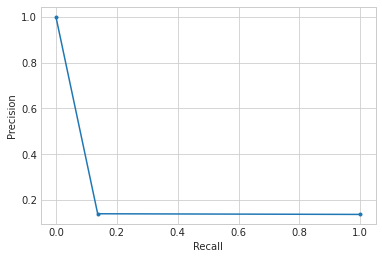

In [181]:
# Initialize empty lists to store evaluation metrics
baseline_precision = []
baseline_recalls = []
baseline_f1_scores = []
baseline_pr_aucs = []

# Perform 1000 random draws
for obs in range(1000):
    
    # Generate random binomial draws with probability 0.137
    draw = np.random.binomial(n=1, p=0.137, size=len(birth_train))
  
    # Calculate precision score and append to the list
    precision_obs = precision_score(birth_train.birth_class_binary, draw)
    baseline_precision.append(precision_obs)

    # Calculate recall score and append to the list
    recall_obs = recall_score(birth_train.birth_class_binary, draw)
    baseline_recalls.append(recall_obs)
    
    # Calculate precision-recall curve and AUC
    precision, recall, _ = precision_recall_curve(birth_train.birth_class_binary, draw)
    pr_auc = auc(recall, precision)
    baseline_pr_aucs.append(pr_auc)
    
    # Calculate F1 score and append to the list
    f1 = f1_score(birth_train.birth_class_binary, draw)
    baseline_f1_scores.append(f1)

plt.plot(recall,precision, marker='.', label='Logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')

# Print statistics for recall, F1, and PR AUC scores
print("Here are some statistics for our baseline:")

print("Mean Precision - " + str(round(np.mean(baseline_precision), 6)))
print("Median Precision - " + str(round(np.median(baseline_precision), 6)))

print("Mean Recall - " + str(round(np.mean(baseline_recalls), 6)))
print("Median Recall - " + str(round(np.median(baseline_recalls), 6)))

print("Mean F1 Score - " + str(round(np.mean(baseline_f1_scores), 6)))
print("Median F1 Score - " + str(round(np.median(baseline_f1_scores), 6)))

print("Mean PR AUC - " + str(round(np.mean(baseline_pr_aucs), 6)))
print("Median PR AUC - " + str(round(np.median(baseline_pr_aucs), 6)))

## Pipeline to scale and one-hot encode all features in `birth_train`

In [101]:
# One Hot Encoding of all categorical features

num_cols = ['maternal_age', 'BMI']

cat_cols = ['smoking_status', 'drinking_frequency', 'six_or_more_drinks_occurrence', 
                     'birth_order', 'diabetes', 'mental_health', 'drug_use']

preprocessor = ColumnTransformer(transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
                                               ('num', StandardScaler(), num_cols)],
                                 remainder='passthrough')

birth_train_encoded = preprocessor.fit_transform(birth_train)

In [102]:
# Convert the result back to a DataFrame for easier inspection
columns_after_encoding = preprocessor.get_feature_names_out()

# Custom function to remove prefixes
def remove_prefix(prefix, column_names):
    return [name[len(prefix):] if name.startswith(prefix) else name for name in column_names]

columns_after_encoding = remove_prefix("cat__", columns_after_encoding)
columns_after_encoding = remove_prefix("num__", columns_after_encoding)
columns_after_encoding = remove_prefix("remainder__", columns_after_encoding)

birth_train_encoded = pd.DataFrame(birth_train_encoded, columns=columns_after_encoding)

In [103]:
birth_train_encoded.columns

Index(['smoking_status_Non-smoker', 'smoking_status_Smoker',
       'smoking_status_Unknown', 'drinking_frequency_2to3Weekly',
       'drinking_frequency_2to4Monthly', 'drinking_frequency_4orMoreWeekly',
       'drinking_frequency_Monthly', 'drinking_frequency_Skipped',
       'six_or_more_drinks_occurrence_Daily',
       'six_or_more_drinks_occurrence_LessThanMonthly',
       'six_or_more_drinks_occurrence_Monthly',
       'six_or_more_drinks_occurrence_Never',
       'six_or_more_drinks_occurrence_Skipped',
       'six_or_more_drinks_occurrence_Weekly', 'birth_order_1',
       'birth_order_2', 'birth_order_3', 'diabetes_None', 'diabetes_Type1',
       'diabetes_Type2', 'diabetes_TypeUnknown', 'mental_health_Anxiety',
       'mental_health_Depression', 'mental_health_None', 'mental_health_Other',
       'drug_use_No', 'drug_use_Yes', 'maternal_age', 'BMI', 'person_id',
       'date_of_birth', 'condition_start_date', 'birth_class',
       'gestational_age_at_birth', 'birth_class_binary

Make sure all data types are integers as needed.

In [104]:
cat_feat = ['smoking_status_Non-smoker', 
                   'smoking_status_Smoker', 
                   'smoking_status_Unknown', 
                   'drinking_frequency_2to3Weekly',
                   'drinking_frequency_2to4Monthly',
                   'drinking_frequency_4orMoreWeekly',
                   'drinking_frequency_Monthly',
                   'drinking_frequency_Skipped',
                   'six_or_more_drinks_occurrence_Daily',
                   'six_or_more_drinks_occurrence_LessThanMonthly',
                   'six_or_more_drinks_occurrence_Monthly',
                   'six_or_more_drinks_occurrence_Never',
                   'six_or_more_drinks_occurrence_Skipped',
                   'six_or_more_drinks_occurrence_Weekly',
                   'drug_use_No', 
                   'drug_use_Yes',
                   'birth_order_1',
                   'birth_order_2',
                   'birth_order_3',
                   'diabetes_None',
                   'diabetes_Type1',
                   'diabetes_Type2',
                   'diabetes_TypeUnknown',
                   'mental_health_Anxiety',
                   'mental_health_Depression',
                   'mental_health_None',
                   'mental_health_Other']

# Make sure all encoded variables are integer types
birth_train_encoded.birth_class_binary = birth_train_encoded.birth_class_binary.astype(int)
birth_train_encoded[cat_feat] = birth_train_encoded[cat_feat].astype(int)

In [105]:
birth_train_encoded.sample(10)

,smoking_status_Non-smoker,smoking_status_Smoker,smoking_status_Unknown,drinking_frequency_2to3Weekly,drinking_frequency_2to4Monthly,drinking_frequency_4orMoreWeekly,drinking_frequency_Monthly,drinking_frequency_Skipped,six_or_more_drinks_occurrence_Daily,six_or_more_drinks_occurrence_LessThanMonthly,...,drug_use_No,drug_use_Yes,maternal_age,BMI,person_id,date_of_birth,condition_start_date,birth_class,gestational_age_at_birth,birth_class_binary
2332,0,0,1,0,0,0,1,0,0,0,...,1,0,0.997277,1.011155,1238603,1983-06-15 00:00:00+00:00,2019-07-26,Term,39.0,0
3221,0,0,1,0,0,0,1,0,0,1,...,1,0,-0.467989,0.674325,2688042,1991-06-15 00:00:00+00:00,2019-03-05,Term,41.0,0
4045,0,0,1,1,0,0,0,0,0,0,...,1,0,-0.38426,2.008689,2832828,1993-06-15 00:00:00+00:00,2021-08-27,Term,38.0,0
2925,0,0,1,0,1,0,0,0,0,0,...,1,0,0.866449,0.622506,7246077,1982-06-15 00:00:00+00:00,2017-10-27,Term,40.0,0
6636,0,1,0,0,0,0,1,0,0,0,...,1,0,-0.984321,0.207946,3250876,1994-06-15 00:00:00+00:00,2019-03-22,Term,39.0,0
140,0,0,1,0,0,0,1,0,0,0,...,1,0,0.194869,-1.294832,2407650,1988-06-15 00:00:00+00:00,2019-12-23,Term,38.0,0
5450,1,0,0,0,0,0,1,0,0,0,...,1,0,0.428614,0.272721,3392219,1986-06-15 00:00:00+00:00,2019-04-24,Term,39.0,0
4498,1,0,0,0,0,0,1,0,0,1,...,1,0,-0.08074,-0.077063,2065217,1989-06-15 00:00:00+00:00,2019-05-26,Term,39.0,0
5787,0,1,0,0,0,0,1,0,0,0,...,0,1,1.100194,1.969823,2882679,1981-06-15 00:00:00+00:00,2018-03-01,Preterm,33.142857,1
847,0,0,1,1,0,0,0,0,0,1,...,1,0,0.993788,-0.660038,1041455,1982-06-15 00:00:00+00:00,2018-07-19,Term,39.0,0


## Logistic Regression with No Interactions, all features included

### Defining the model features

These include the following variables:

Continuous:
- Maternal age
- BMI

Categorical:
- Smoking Status
- Drinking frequency
- Binge drinking
- Drug use
- Diabetes
- Mental health
- Birth order

In [98]:
model_feat = ['maternal_age', 'BMI']

# Add one-hot encoded lifestyle features
model_feat.extend(['smoking_status_Non-smoker', 
                   'smoking_status_Smoker', 
                   'smoking_status_Unknown', 
                   'drinking_frequency_2to3Weekly',
                   'drinking_frequency_2to4Monthly',
                   'drinking_frequency_4orMoreWeekly',
                   'drinking_frequency_Monthly',
                   'drinking_frequency_Skipped',
                   'six_or_more_drinks_occurrence_Daily',
                   'six_or_more_drinks_occurrence_LessThanMonthly',
                   'six_or_more_drinks_occurrence_Monthly',
                   'six_or_more_drinks_occurrence_Never',
                   'six_or_more_drinks_occurrence_Skipped',
                   'six_or_more_drinks_occurrence_Weekly',
                   'drug_use_No', 
                   'drug_use_Yes'])

# Add one-hot encoded health features
model_feat.extend(['birth_order_1',
                   'birth_order_2',
                   'birth_order_3',
                   'diabetes_None',
                   'diabetes_Type1',
                   'diabetes_Type2',
                   'diabetes_TypeUnknown',
                   'mental_health_Anxiety',
                   'mental_health_Depression',
                   'mental_health_None',
                   'mental_health_Other'])


### Create Stratified KFold Object

We will perform a stratified 10-fold cross-validation due to the imbalanced class sizes in the response variable.

In [99]:
kfold = StratifiedKFold(n_splits=10,
                        shuffle=True,
                        random_state=123)

num_splits = 10

### Run Model with Cross Validation

---Metrics for Fold  1 ---
Precision:  0.18478260869565216
Recall:  0.53125
F1:  0.2741935483870968
AUC:  0.22645255238391182
Confusion Matrix: 
[[381 225]
 [ 45  51]]
 
---Metrics for Fold  2 ---
Precision:  0.17204301075268819
Recall:  0.5
F1:  0.256
AUC:  0.18352771597469553
Confusion Matrix: 
[[375 231]
 [ 48  48]]
 
---Metrics for Fold  3 ---
Precision:  0.15719063545150502
Recall:  0.4895833333333333
F1:  0.2379746835443038
AUC:  0.1986451724482373
Confusion Matrix: 
[[354 252]
 [ 49  47]]
 
---Metrics for Fold  4 ---
Precision:  0.15463917525773196
Recall:  0.46875
F1:  0.23255813953488375
AUC:  0.2301217122631118
Confusion Matrix: 
[[360 246]
 [ 51  45]]
 
---Metrics for Fold  5 ---
Precision:  0.19480519480519481
Recall:  0.4639175257731959
F1:  0.274390243902439
AUC:  0.19414418892151053
Confusion Matrix: 
[[419 186]
 [ 52  45]]
 
---Metrics for Fold  6 ---
Precision:  0.17785234899328858
Recall:  0.5463917525773195
F1:  0.2683544303797468
AUC:  0.2007249710313913
Confusion M

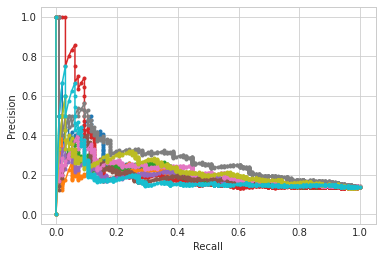

In [100]:
# Initialize arrays to store evaluation metrics
prec = np.zeros(num_splits)
recalls = np.zeros(num_splits)
f1 = np.zeros(num_splits)
pr_auc = np.zeros(num_splits)

# Start counter
counter = 0

# Loop through each KFold split
for train_index, test_index in kfold.split(birth_train_encoded, birth_train_encoded.birth_class_binary):
    birth_tt = birth_train_encoded.iloc[train_index]
    birth_ho = birth_train_encoded.iloc[test_index]

    log_reg = LogisticRegression(penalty='l2', class_weight='balanced', max_iter=1000)
        
    log_reg.fit(birth_tt[model_feat].values, birth_tt.birth_class_binary.values)
        
    pred = log_reg.predict(birth_ho[model_feat].values)
    
    prec[counter] = precision_score(birth_ho.birth_class_binary.values, pred)
    recalls[counter] = recall_score(birth_ho.birth_class_binary.values, pred)
    f1[counter] = f1_score(birth_ho.birth_class_binary.values, pred)
    
    # Calculate precision-recall curve and AUC
    precision, recall, _ = precision_recall_curve(birth_ho.birth_class_binary.values, log_reg.predict_proba(birth_ho[model_feat].values)[:,1])
    pr_auc[counter] = auc(recall, precision)
    
    # Calculate confusion matrix
    conf_mat = confusion_matrix(birth_ho.birth_class_binary.values, pred)
    
    print('---Metrics for Fold ', counter+1,'---')
    print('Precision: ', prec[counter])
    print('Recall: ', recalls[counter])
    print('F1: ', f1[counter])
    print('AUC: ', pr_auc[counter])
    print('Confusion Matrix: ')
    print(conf_mat)
    print(' ')
    
    plt.plot(recall,precision, marker='.', label='Logistic')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    
    #Adjust counter for next k-fold split
    counter += 1

In [101]:
# Print statistics for recall, F1, and PR AUC scores
print("Here are the statistics for the recall score of our model:")

print("Mean Precision - " + str(round(np.mean(precision), 6)))
print("Median Precision - " + str(round(np.median(precision), 6)))

print("Mean Recall - " + str(round(np.mean(recalls), 6)))
print("Median Recall - " + str(round(np.median(recalls), 6)))

print("Mean F1 Score - " + str(round(np.mean(f1), 6)))
print("Median F1 Score - " + str(round(np.median(f1), 6)))

print("Mean PR AUC - " + str(round(np.mean(pr_auc), 6)))
print("Median PR AUC - " + str(round(np.median(pr_auc), 6)))

Here are the statistics for the recall score of our model:
Mean Precision - 0.171451
Median Precision - 0.150812
Mean Recall - 0.529156
Median Recall - 0.515625
Mean F1 Score - 0.265237
Median F1 Score - 0.271274
Mean PR AUC - 0.213471
Median PR AUC - 0.206


## Logistic Regression with No Interactions, selected features only

### Defining the model features

Based on EDA, we will select only features that gave a clear difference between preterm and term to include in our model.

These include the following variables:

Categorical:
- Drug use
- Diabetes

In [134]:
model_feat = ['drug_use_No',
                'drug_use_Yes',
                'diabetes_None',
                'diabetes_Type1',
                'diabetes_Type2',
                'diabetes_TypeUnknown']

### Create Stratified KFold Object

We will perform a stratified 10-fold cross-validation due to the imbalanced class sizes in the response variable.

In [135]:
kfold = StratifiedKFold(n_splits=10,
                        shuffle=True,
                        random_state=123)

num_splits = 10

### Run Model with Cross Validation

---Metrics for Fold  1 ---
Precision:  0.22727272727272727
Recall:  0.2604166666666667
F1:  0.24271844660194178
AUC:  0.22126108844858844
Confusion Matrix: 
[[521  85]
 [ 71  25]]
 
---Metrics for Fold  2 ---
Precision:  0.184
Recall:  0.23958333333333334
F1:  0.2081447963800905
AUC:  0.16489300769751353
Confusion Matrix: 
[[504 102]
 [ 73  23]]
 
---Metrics for Fold  3 ---
Precision:  0.224
Recall:  0.2916666666666667
F1:  0.25339366515837103
AUC:  0.21902828652828657
Confusion Matrix: 
[[509  97]
 [ 68  28]]
 
---Metrics for Fold  4 ---
Precision:  0.22413793103448276
Recall:  0.2708333333333333
F1:  0.24528301886792453
AUC:  0.26305534910607375
Confusion Matrix: 
[[516  90]
 [ 70  26]]
 
---Metrics for Fold  5 ---
Precision:  0.17857142857142858
Recall:  0.15463917525773196
F1:  0.16574585635359115
AUC:  0.17704428233536784
Confusion Matrix: 
[[536  69]
 [ 82  15]]
 
---Metrics for Fold  6 ---
Precision:  0.1875
Recall:  0.24742268041237114
F1:  0.21333333333333335
AUC:  0.200289455

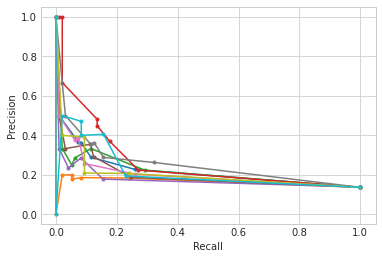

In [136]:
# Initialize arrays to store evaluation metrics
prec = np.zeros(num_splits)
recalls = np.zeros(num_splits)
f1 = np.zeros(num_splits)
pr_auc = np.zeros(num_splits)

# Start counter
counter = 0

# Loop through each KFold split
for train_index, test_index in kfold.split(birth_train_encoded, birth_train_encoded.birth_class_binary):
    birth_tt = birth_train_encoded.iloc[train_index]
    birth_ho = birth_train_encoded.iloc[test_index]

    log_reg = LogisticRegression(penalty='l2', class_weight='balanced', max_iter=1000, random_state=456)
        
    log_reg.fit(birth_tt[model_feat].values, birth_tt.birth_class_binary.values)
        
    pred = log_reg.predict(birth_ho[model_feat].values)
    
    prec[counter] = precision_score(birth_ho.birth_class_binary.values, pred)
    recalls[counter] = recall_score(birth_ho.birth_class_binary.values, pred)
    f1[counter] = f1_score(birth_ho.birth_class_binary.values, pred)
    
    # Calculate precision-recall curve and AUC
    precision, recall, _ = precision_recall_curve(birth_ho.birth_class_binary.values, log_reg.predict_proba(birth_ho[model_feat].values)[:,1])
    pr_auc[counter] = auc(recall, precision)
    
    # Calculate confusion matrix
    conf_mat = confusion_matrix(birth_ho.birth_class_binary.values, pred)
    
    print('---Metrics for Fold ', counter+1,'---')
    print('Precision: ', prec[counter])
    print('Recall: ', recalls[counter])
    print('F1: ', f1[counter])
    print('AUC: ', pr_auc[counter])
    print('Confusion Matrix: ')
    print(conf_mat)
    print(' ')
    
    plt.plot(recall,precision, marker='.', label='Logistic')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    
    #Adjust counter for next k-fold split
    counter += 1

In [137]:
# Print statistics for recall, F1, and PR AUC scores
print("Here are the statistics for the recall score of our model:")

print("Mean Precision - " + str(round(np.mean(precision), 6)))
print("Median Precision - " + str(round(np.median(precision), 6)))

print("Mean Recall - " + str(round(np.mean(recalls), 6)))
print("Median Recall - " + str(round(np.median(recalls), 6)))

print("Mean F1 Score - " + str(round(np.mean(f1), 6)))
print("Median F1 Score - " + str(round(np.median(f1), 6)))

print("Mean PR AUC - " + str(round(np.mean(pr_auc), 6)))
print("Median PR AUC - " + str(round(np.median(pr_auc), 6)))

Here are the statistics for the recall score of our model:
Mean Precision - 0.388454
Median Precision - 0.402703
Mean Recall - 0.251665
Median Recall - 0.25392
Mean F1 Score - 0.22794
Median F1 Score - 0.225266
Mean PR AUC - 0.212452
Median PR AUC - 0.210038


## Logistic Regression with Interactions

### Defining the model features

We will only use interactions between continuous variables, because there are not enough observations in each of the categorical variables to include interaction terms.

These include the following variables:

Continuous:
- Maternal age
- BMI

Categorical:
- Smoking Status
- Drinking frequency
- Binge drinking
- Drug use
- Diabetes
- Mental health
- Birth order

Interactions: 
- Maternal age & BMI

Create interaction features and add to train and test data.

In [248]:
# Specify which features for interaction
interaction_features = ['maternal_age', 'BMI']

# Create a pipeline with PolynomialFeatures
degree = 2  # Set the degree of interaction terms
poly = PolynomialFeatures(degree, interaction_only=True, include_bias=False)
birth_train_poly = poly.fit_transform(birth_train_encoded[interaction_features])

# Concatenate the polynomial features with the original features
birth_train = pd.concat([birth_train_encoded, pd.DataFrame(birth_train_poly, columns=poly.get_feature_names_out(interaction_features))], axis=1)
#birth_train = birth_train.drop(columns=birth_train.columns[[-2, -3]])

In [249]:
birth_train.columns

Index(['smoking_status_Non-smoker', 'smoking_status_Smoker',
       'smoking_status_Unknown', 'drinking_frequency_2to3Weekly',
       'drinking_frequency_2to4Monthly', 'drinking_frequency_4orMoreWeekly',
       'drinking_frequency_Monthly', 'drinking_frequency_Skipped',
       'six_or_more_drinks_occurrence_Daily',
       'six_or_more_drinks_occurrence_LessThanMonthly',
       'six_or_more_drinks_occurrence_Monthly',
       'six_or_more_drinks_occurrence_Never',
       'six_or_more_drinks_occurrence_Skipped',
       'six_or_more_drinks_occurrence_Weekly', 'birth_order_1',
       'birth_order_2', 'birth_order_3', 'diabetes_None', 'diabetes_Type1',
       'diabetes_Type2', 'diabetes_TypeUnknown', 'mental_health_Anxiety',
       'mental_health_Depression', 'mental_health_None', 'mental_health_Other',
       'drug_use_No', 'drug_use_Yes', 'maternal_age', 'BMI', 'person_id',
       'date_of_birth', 'condition_start_date', 'birth_class',
       'gestational_age_at_birth', 'birth_class_binary

Define all features for model:

In [250]:
model_feat = ['maternal_age', 'BMI']

# Add one-hot encoded lifestyle features
model_feat.extend(['smoking_status_Non-smoker', 
                   'smoking_status_Smoker', 
                   'smoking_status_Unknown', 
                   'drinking_frequency_2to3Weekly',
                   'drinking_frequency_2to4Monthly',
                   'drinking_frequency_4orMoreWeekly',
                   'drinking_frequency_Monthly',
                   'drinking_frequency_Skipped',
                   'six_or_more_drinks_occurrence_Daily',
                   'six_or_more_drinks_occurrence_LessThanMonthly',
                   'six_or_more_drinks_occurrence_Monthly',
                   'six_or_more_drinks_occurrence_Never',
                   'six_or_more_drinks_occurrence_Skipped',
                   'six_or_more_drinks_occurrence_Weekly',
                   'drug_use_No', 
                   'drug_use_Yes'])

# Add one-hot encoded health features
model_feat.extend(['birth_order_1',
                   'birth_order_2',
                   'birth_order_3',
                   'diabetes_None',
                   'diabetes_Type1',
                   'diabetes_Type2',
                   'diabetes_TypeUnknown',
                   'mental_health_Anxiety',
                   'mental_health_Depression',
                   'mental_health_None',
                   'mental_health_Other'])

# Add interaction term
model_feat.extend(['maternal_age BMI'])

### Create Stratified KFold Object

We will perform a stratified 10-fold cross-validation due to the imbalanced class sizes in the response variable.

In [251]:
kfold = StratifiedKFold(n_splits=10,
                        shuffle=True,
                        random_state=123)

num_splits = 10

### Run Model with Cross Validation

---Metrics for Fold  1 ---
Precision:  0.18631178707224336
Recall:  0.5104166666666666
F1:  0.27298050139275765
AUC:  0.23678513042451416
Confusion Matrix: 
[[392 214]
 [ 47  49]]
 
---Metrics for Fold  2 ---
Precision:  0.17216117216117216
Recall:  0.4895833333333333
F1:  0.25474254742547425
AUC:  0.17787834837408006
Confusion Matrix: 
[[380 226]
 [ 49  47]]
 
---Metrics for Fold  3 ---
Precision:  0.15827338129496402
Recall:  0.4583333333333333
F1:  0.23529411764705882
AUC:  0.1871418088969903
Confusion Matrix: 
[[372 234]
 [ 52  44]]
 
---Metrics for Fold  4 ---
Precision:  0.16304347826086957
Recall:  0.46875
F1:  0.24193548387096772
AUC:  0.2311009362963825
Confusion Matrix: 
[[375 231]
 [ 51  45]]
 
---Metrics for Fold  5 ---
Precision:  0.1939655172413793
Recall:  0.4639175257731959
F1:  0.2735562310030395
AUC:  0.1945470990300905
Confusion Matrix: 
[[418 187]
 [ 52  45]]
 
---Metrics for Fold  6 ---
Precision:  0.16896551724137931
Recall:  0.5051546391752577
F1:  0.253229974160

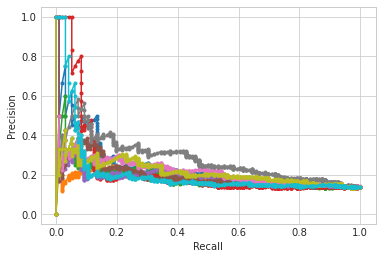

In [252]:
# Initialize arrays to store evaluation metrics
prec = np.zeros(num_splits)
recalls = np.zeros(num_splits)
f1 = np.zeros(num_splits)
pr_auc = np.zeros(num_splits)

# Start counter
counter = 0

# Loop through each KFold split
for train_index, test_index in kfold.split(birth_train, birth_train.birth_class_binary):
    birth_tt = birth_train.iloc[train_index]
    birth_ho = birth_train.iloc[test_index]

    log_reg = LogisticRegression(penalty='l2', class_weight='balanced', max_iter=1000)
        
    log_reg.fit(birth_tt[model_feat].values, birth_tt.birth_class_binary.values)
        
    pred = log_reg.predict(birth_ho[model_feat].values)
    
    prec[counter] = precision_score(birth_ho.birth_class_binary.values, pred)
    recalls[counter] = recall_score(birth_ho.birth_class_binary.values, pred)
    f1[counter] = f1_score(birth_ho.birth_class_binary.values, pred)
    
    # Calculate precision-recall curve and AUC
    precision, recall, _ = precision_recall_curve(birth_ho.birth_class_binary.values, log_reg.predict_proba(birth_ho[model_feat].values)[:,1])
    pr_auc[counter] = auc(recall, precision)
    
    # Calculate confusion matrix
    conf_mat = confusion_matrix(birth_ho.birth_class_binary.values, pred)
    
    print('---Metrics for Fold ', counter+1,'---')
    print('Precision: ', prec[counter])
    print('Recall: ', recalls[counter])
    print('F1: ', f1[counter])
    print('AUC: ', pr_auc[counter])
    print('Confusion Matrix: ')
    print(conf_mat)
    print(' ')
    
    plt.plot(recall,precision, marker='.', label='Logistic')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    
    #Adjust counter for next k-fold split
    counter += 1

In [253]:
# Print statistics for recall, F1, and PR AUC scores
print("Here are the statistics for the recall score of our model:")

print("Mean Precision - " + str(round(np.mean(precision), 6)))
print("Median Precision - " + str(round(np.median(precision), 6)))

print("Mean Recall - " + str(round(np.mean(recalls), 6)))
print("Median Recall - " + str(round(np.median(recalls), 6)))

print("Mean F1 Score - " + str(round(np.mean(f1), 6)))
print("Median F1 Score - " + str(round(np.median(f1), 6)))

print("Mean PR AUC - " + str(round(np.mean(pr_auc), 6)))
print("Median PR AUC - " + str(round(np.median(pr_auc), 6)))

Here are the statistics for the recall score of our model:
Mean Precision - 0.178378
Median Precision - 0.155405
Mean Recall - 0.513574
Median Recall - 0.497369
Mean F1 Score - 0.265916
Median F1 Score - 0.263862
Mean PR AUC - 0.214595
Median PR AUC - 0.212092


## SVC

### Defining the model features

We will use the features that gave us the best metrics when using logistic regression.

These include the following variables:

Continuous:
- Maternal age
- BMI

Categorical:
- Smoking Status
- Drinking frequency
- Binge drinking
- Drug use
- Diabetes
- Mental health
- Birth order

In [121]:
model_feat = ['maternal_age', 'BMI']

# Add one-hot encoded lifestyle features
model_feat.extend(['smoking_status_Non-smoker', 
                   'smoking_status_Smoker', 
                   'smoking_status_Unknown', 
                   'drinking_frequency_2to3Weekly',
                   'drinking_frequency_2to4Monthly',
                   'drinking_frequency_4orMoreWeekly',
                   'drinking_frequency_Monthly',
                   'drinking_frequency_Skipped',
                   'six_or_more_drinks_occurrence_Daily',
                   'six_or_more_drinks_occurrence_LessThanMonthly',
                   'six_or_more_drinks_occurrence_Monthly',
                   'six_or_more_drinks_occurrence_Never',
                   'six_or_more_drinks_occurrence_Skipped',
                   'six_or_more_drinks_occurrence_Weekly',
                   'drug_use_No', 
                   'drug_use_Yes'])

# Add one-hot encoded health features
model_feat.extend(['birth_order_1',
                   'birth_order_2',
                   'birth_order_3',
                   'diabetes_None',
                   'diabetes_Type1',
                   'diabetes_Type2',
                   'diabetes_TypeUnknown',
                   'mental_health_Anxiety',
                   'mental_health_Depression',
                   'mental_health_None',
                   'mental_health_Other'])


### Create Stratified KFold Object

We will perform a stratified 10-fold cross-validation due to the imbalanced class sizes in the response variable.

In [122]:
kfold = StratifiedKFold(n_splits=10,
                        shuffle=True,
                        random_state=123)

num_splits = 10

### Run Model with Cross Validation

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


---Metrics for Fold  1 ---
Precision:  0.16923076923076924
Recall:  0.4583333333333333
F1:  0.24719101123595508
AUC:  0.1993182987526695
Confusion Matrix: 
[[390 216]
 [ 52  44]]
 


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


---Metrics for Fold  2 ---
Precision:  0.182648401826484
Recall:  0.4166666666666667
F1:  0.25396825396825395
AUC:  0.18453381066454108
Confusion Matrix: 
[[427 179]
 [ 56  40]]
 


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


---Metrics for Fold  3 ---
Precision:  0.1446280991735537
Recall:  0.3645833333333333
F1:  0.2071005917159763
AUC:  0.1834834402682738
Confusion Matrix: 
[[399 207]
 [ 61  35]]
 


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


---Metrics for Fold  4 ---
Precision:  0.15789473684210525
Recall:  0.40625
F1:  0.22740524781341104
AUC:  0.1915835612283596
Confusion Matrix: 
[[398 208]
 [ 57  39]]
 


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


---Metrics for Fold  5 ---
Precision:  0.18974358974358974
Recall:  0.38144329896907214
F1:  0.2534246575342466
AUC:  0.1868801097393413
Confusion Matrix: 
[[447 158]
 [ 60  37]]
 


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


---Metrics for Fold  6 ---
Precision:  0.16908212560386474
Recall:  0.36082474226804123
F1:  0.23026315789473684
AUC:  0.16622137279706517
Confusion Matrix: 
[[433 172]
 [ 62  35]]
 


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


---Metrics for Fold  7 ---
Precision:  0.20640569395017794
Recall:  0.6041666666666666
F1:  0.30769230769230765
AUC:  0.1870262324079653
Confusion Matrix: 
[[382 223]
 [ 38  58]]
 


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


---Metrics for Fold  8 ---
Precision:  0.20284697508896798
Recall:  0.59375
F1:  0.3023872679045093
AUC:  0.28080228930250545
Confusion Matrix: 
[[381 224]
 [ 39  57]]
 


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


---Metrics for Fold  9 ---
Precision:  0.20318725099601595
Recall:  0.53125
F1:  0.29394812680115273
AUC:  0.19240434769215048
Confusion Matrix: 
[[405 200]
 [ 45  51]]
 


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


---Metrics for Fold  10 ---
Precision:  0.15767634854771784
Recall:  0.3958333333333333
F1:  0.22551928783382785
AUC:  0.1543507298877857
Confusion Matrix: 
[[402 203]
 [ 58  38]]
 


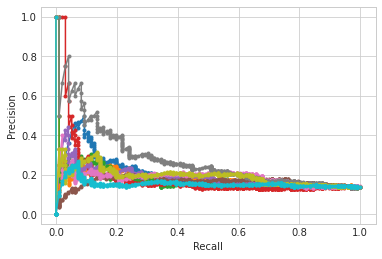

In [132]:
# Define weight as inversely proportional to class frequencies (in SVC documentation)
weights = len(birth_train_encoded) / (2 * np.bincount(birth_train_encoded.birth_class_binary))

# Initialize arrays to store evaluation metrics
svc_prec = np.zeros(num_splits)
svc_recalls = np.zeros(num_splits)
svc_f1 = np.zeros(num_splits)
svc_pr_auc = np.zeros(num_splits)

# Initialize list to store predictions
svc_predictions = []

counter = 0

for train_index, test_index in kfold.split(birth_train_encoded, birth_train_encoded.birth_class_binary):
    birth_tt = birth_train_encoded.iloc[train_index]
    birth_ho = birth_train_encoded.iloc[test_index]

    # Create dictionary for class weights, with preterm birth having a heavier weight
    class_weights = {0: weights[0], 1: weights[1]}  

    # Add a column for class weights to birth_tt
    birth_tt = birth_tt.copy()
    birth_tt['class_weights'] = birth_tt['birth_class_binary'].map(class_weights)

    # Create the SVC
    svc = SVC(probability=True, random_state=404, class_weight='balanced')

    # Fit the pipeline on training data
    svc.fit(birth_tt[model_feat].values, birth_tt.birth_class_binary.values) 
    #        sample_weight=birth_tt.class_weights.values)

    # Predict on the holdout data
    svc_pred = svc.predict(birth_ho[model_feat].values)

    # Append predictions to the list
    svc_predictions.append(svc_pred)

    # Calculate evaluation metrics
    svc_prec[counter] = precision_score(birth_ho.birth_class_binary.values, svc_pred)
    svc_recalls[counter] = recall_score(birth_ho.birth_class_binary.values, svc_pred)
    svc_f1[counter] = f1_score(birth_ho.birth_class_binary.values, svc_pred)

    # Calculate precision-recall curve and AUC
    svc_precision, svc_recall, _ = precision_recall_curve(birth_ho.birth_class_binary, 
                                                          svc.predict_proba(birth_ho[model_feat])[:, 1])
    svc_pr_auc[counter] = auc(svc_recall, svc_precision)

    # Calculate confusion matrix
    conf_mat = confusion_matrix(birth_ho.birth_class_binary.values, svc_pred)

    # Print all metrics
    print('---Metrics for Fold ', counter+1,'---')
    print('Precision: ', svc_prec[counter])
    print('Recall: ', svc_recalls[counter])
    print('F1: ', svc_f1[counter])
    print('AUC: ', svc_pr_auc[counter])
    print('Confusion Matrix: ')
    print(conf_mat)
    print(' ')
    
    plt.plot(svc_recall, svc_precision, marker='.', label='SVC')
    plt.xlabel('Recall')
    plt.ylabel('Precision')

    # Adjust counter for the next k-fold split
    counter += 1


In [133]:
# Print statistics for recall, F1, and PR AUC scores
print("Here are the statistics for the recall score of our model:")

print("Mean Precision - " + str(round(np.mean(svc_prec), 6)))
print("Median Precision - " + str(round(np.median(svc_prec), 6)))

print("Mean Recall - " + str(round(np.mean(svc_recalls), 6)))
print("Median Recall - " + str(round(np.median(svc_recalls), 6)))

print("Mean F1 Score - " + str(round(np.mean(svc_f1), 6)))
print("Median F1 Score - " + str(round(np.median(svc_f1), 6)))

print("Mean PR AUC - " + str(round(np.mean(svc_pr_auc), 6)))
print("Median PR AUC - " + str(round(np.median(svc_pr_auc), 6)))

Here are the statistics for the recall score of our model:
Mean Precision - 0.178334
Median Precision - 0.17594
Mean Recall - 0.45131
Median Recall - 0.411458
Mean F1 Score - 0.25489
Median F1 Score - 0.250308
Mean PR AUC - 0.19266
Median PR AUC - 0.186953


## ROSE Method for Unbalanced Data

Install imbalanced learn package and import libraries:

In [289]:
# Only need to do this once
#pip install -U imbalanced-learn

In [106]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import KFold

### use RandomOverSampler to oversample minority class

In [107]:
print('Original dataset: ')
print(birth_train_encoded.birth_class_binary.value_counts())
print('')

ros = RandomOverSampler(random_state=42)

birth_train_rose, birth_train_rose.birth_class_binary = ros.fit_resample(birth_train_encoded, birth_train_encoded.birth_class_binary)

print('Oversampled dataset: ')
print(birth_train_rose.birth_class_binary.value_counts())

Original dataset: 
0    6054
1     962
Name: birth_class_binary, dtype: int64

Oversampled dataset: 
0    6054
1    6054
Name: birth_class_binary, dtype: int64


### Run a new baseline model, with oversampled minority class data

Find proportion of response variable that falls into either category.

In [108]:
normalized_value_counts = birth_train_rose['birth_class'].value_counts(normalize=True)

# Display the normalized value counts
print("Normalized value counts:")
print(normalized_value_counts)

Normalized value counts:
Term       0.5
Preterm    0.5
Name: birth_class, dtype: float64


Here are some statistics for our baseline:
Mean Precision - 0.500104
Median Precision - 0.500083
Mean Recall - 0.500177
Median Recall - 0.500165
Mean F1 Score - 0.50013
Median F1 Score - 0.500124
Mean PR AUC - 0.625096
Median PR AUC - 0.625042


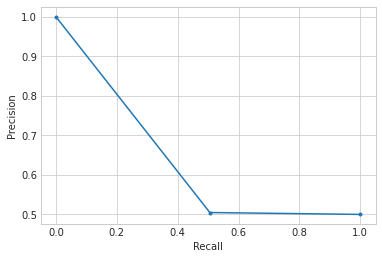

In [109]:
# Initialize empty lists to store evaluation metrics
baseline_precision = []
baseline_recalls = []
baseline_f1_scores = []
baseline_pr_aucs = []

# Perform 1000 random draws
for obs in range(1000):
    
    # Generate random binomial draws with probability 0.5
    draw = np.random.binomial(n=1, p=0.5, size=len(birth_train_rose))
  
    # Calculate precision score and append to the list
    precision_obs = precision_score(birth_train_rose.birth_class_binary, draw)
    baseline_precision.append(precision_obs)

    # Calculate recall score and append to the list
    recall_obs = recall_score(birth_train_rose.birth_class_binary, draw)
    baseline_recalls.append(recall_obs)
    
    # Calculate precision-recall curve and AUC
    precision, recall, _ = precision_recall_curve(birth_train_rose.birth_class_binary, draw)
    pr_auc = auc(recall, precision)
    baseline_pr_aucs.append(pr_auc)
    
    # Calculate F1 score and append to the list
    f1 = f1_score(birth_train_rose.birth_class_binary, draw)
    baseline_f1_scores.append(f1)

plt.plot(recall,precision, marker='.', label='Logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')

# Print statistics for recall, F1, and PR AUC scores
print("Here are some statistics for our baseline:")

print("Mean Precision - " + str(round(np.mean(baseline_precision), 6)))
print("Median Precision - " + str(round(np.median(baseline_precision), 6)))

print("Mean Recall - " + str(round(np.mean(baseline_recalls), 6)))
print("Median Recall - " + str(round(np.median(baseline_recalls), 6)))

print("Mean F1 Score - " + str(round(np.mean(baseline_f1_scores), 6)))
print("Median F1 Score - " + str(round(np.median(baseline_f1_scores), 6)))

print("Mean PR AUC - " + str(round(np.mean(baseline_pr_aucs), 6)))
print("Median PR AUC - " + str(round(np.median(baseline_pr_aucs), 6)))

### Defining the model features

We will use the features that gave us the best metrics when using logistic regression.

These include the following variables:

Continuous:
- Maternal age
- BMI

Categorical:
- Smoking Status
- Drinking frequency
- Binge drinking
- Drug use
- Diabetes
- Mental health
- Birth order

In [114]:
model_feat = ['maternal_age', 'BMI']

# Add one-hot encoded lifestyle features
model_feat.extend(['smoking_status_Non-smoker', 
                   'smoking_status_Smoker', 
                   'smoking_status_Unknown', 
                   'drinking_frequency_2to3Weekly',
                   'drinking_frequency_2to4Monthly',
                   'drinking_frequency_4orMoreWeekly',
                   'drinking_frequency_Monthly',
                   'drinking_frequency_Skipped',
                   'six_or_more_drinks_occurrence_Daily',
                   'six_or_more_drinks_occurrence_LessThanMonthly',
                   'six_or_more_drinks_occurrence_Monthly',
                   'six_or_more_drinks_occurrence_Never',
                   'six_or_more_drinks_occurrence_Skipped',
                   'six_or_more_drinks_occurrence_Weekly',
                   'drug_use_No', 
                   'drug_use_Yes'])

# Add one-hot encoded health features
model_feat.extend(['birth_order_1',
                   'birth_order_2',
                   'birth_order_3',
                   'diabetes_None',
                   'diabetes_Type1',
                   'diabetes_Type2',
                   'diabetes_TypeUnknown',
                   'mental_health_Anxiety',
                   'mental_health_Depression',
                   'mental_health_None',
                   'mental_health_Other'])

### Create Stratified KFold Object

We will perform a stratified 10-fold cross-validation due to the imbalanced class sizes in the response variable.

In [115]:
kfold = KFold(n_splits=10, shuffle=True, random_state=123)

num_splits = 10

### Run Model with Cross Validation

---Metrics for Fold  1 ---
Precision:  0.6
Recall:  0.2469982847341338
F1:  0.34993924665856624
AUC:  0.5883477012990623
Confusion Matrix: 
[[532  96]
 [439 144]]
 
---Metrics for Fold  2 ---
Precision:  0.6615384615384615
Recall:  0.2824302134646962
F1:  0.3958573072497123
AUC:  0.6345833013554736
Confusion Matrix: 
[[514  88]
 [437 172]]
 
---Metrics for Fold  3 ---
Precision:  0.6352941176470588
Recall:  0.2704507512520868
F1:  0.37939110070257603
AUC:  0.5973154989020092
Confusion Matrix: 
[[519  93]
 [437 162]]
 
---Metrics for Fold  4 ---
Precision:  0.6491935483870968
Recall:  0.26480263157894735
F1:  0.3761682242990654
AUC:  0.6198668692465551
Confusion Matrix: 
[[516  87]
 [447 161]]
 
---Metrics for Fold  5 ---
Precision:  0.5907172995780591
Recall:  0.23608768971332209
F1:  0.3373493975903614
AUC:  0.5802719165794785
Confusion Matrix: 
[[521  97]
 [453 140]]
 
---Metrics for Fold  6 ---
Precision:  0.6382113821138211
Recall:  0.26430976430976433
F1:  0.3738095238095238
AUC: 

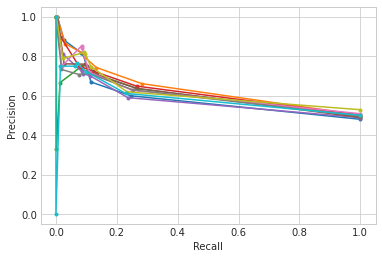

In [116]:
# Initialize arrays to store evaluation metrics
prec = np.zeros(num_splits)
recalls = np.zeros(num_splits)
f1 = np.zeros(num_splits)
pr_auc = np.zeros(num_splits)

# Start counter
counter = 0

# Loop through each KFold split
for train_index, test_index in kfold.split(birth_train_rose, birth_train_rose.birth_class_binary):
    birth_tt = birth_train_rose.iloc[train_index]
    birth_ho = birth_train_rose.iloc[test_index]

    log_reg = LogisticRegression(max_iter=1000)
        
    log_reg.fit(birth_tt[model_feat].values, birth_tt.birth_class_binary.values)
        
    pred = log_reg.predict(birth_ho[model_feat].values)
    
    prec[counter] = precision_score(birth_ho.birth_class_binary.values, pred)
    recalls[counter] = recall_score(birth_ho.birth_class_binary.values, pred)
    f1[counter] = f1_score(birth_ho.birth_class_binary.values, pred)
    
    # Calculate precision-recall curve and AUC
    precision, recall, _ = precision_recall_curve(birth_ho.birth_class_binary.values, log_reg.predict_proba(birth_ho[model_feat].values)[:,1])
    pr_auc[counter] = auc(recall, precision)
    
    # Calculate confusion matrix
    conf_mat = confusion_matrix(birth_ho.birth_class_binary.values, pred)
    
    print('---Metrics for Fold ', counter+1,'---')
    print('Precision: ', prec[counter])
    print('Recall: ', recalls[counter])
    print('F1: ', f1[counter])
    print('AUC: ', pr_auc[counter])
    print('Confusion Matrix: ')
    print(conf_mat)
    print(' ')
    
    plt.plot(recall,precision, marker='.', label='Logistic')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    
    #Adjust counter for next k-fold split
    counter += 1

In [117]:
# Print statistics for recall, F1, and PR AUC scores
print("Here are the statistics for the recall score of our model:")

print("Mean Precision - " + str(round(np.mean(precision), 6)))
print("Median Precision - " + str(round(np.median(precision), 6)))

print("Mean Recall - " + str(round(np.mean(recalls), 6)))
print("Median Recall - " + str(round(np.median(recalls), 6)))

print("Mean F1 Score - " + str(round(np.mean(f1), 6)))
print("Median F1 Score - " + str(round(np.median(f1), 6)))

print("Mean PR AUC - " + str(round(np.mean(pr_auc), 6)))
print("Median PR AUC - " + str(round(np.median(pr_auc), 6)))

Here are the statistics for the recall score of our model:
Mean Precision - 0.637564
Median Precision - 0.736446
Mean Recall - 0.253141
Median Recall - 0.251663
Mean F1 Score - 0.360461
Median F1 Score - 0.359505
Mean PR AUC - 0.603774
Median PR AUC - 0.603205


# Run Chosen Model on Test Data

## Pipeline to scale and one-hot encode all features in `birth_test`

In [118]:
# One Hot Encoding of all categorical features

num_cols = ['maternal_age', 'BMI']

cat_cols = ['smoking_status', 'drinking_frequency', 'six_or_more_drinks_occurrence', 
                     'birth_order', 'diabetes', 'mental_health', 'drug_use']

preprocessor = ColumnTransformer(transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
                                               ('num', StandardScaler(), num_cols)],
                                 remainder='passthrough')

birth_test_encoded = preprocessor.fit_transform(birth_test)

In [119]:
# Convert the result back to a DataFrame for easier inspection
columns_after_encoding = preprocessor.get_feature_names_out()

# Custom function to remove prefixes
def remove_prefix(prefix, column_names):
    return [name[len(prefix):] if name.startswith(prefix) else name for name in column_names]

columns_after_encoding = remove_prefix("cat__", columns_after_encoding)
columns_after_encoding = remove_prefix("num__", columns_after_encoding)
columns_after_encoding = remove_prefix("remainder__", columns_after_encoding)

birth_test_encoded = pd.DataFrame(birth_test_encoded, columns=columns_after_encoding)

In [120]:
birth_test_encoded.columns

Index(['smoking_status_Non-smoker', 'smoking_status_Smoker',
       'smoking_status_Unknown', 'drinking_frequency_2to3Weekly',
       'drinking_frequency_2to4Monthly', 'drinking_frequency_4orMoreWeekly',
       'drinking_frequency_Monthly', 'drinking_frequency_Skipped',
       'six_or_more_drinks_occurrence_Daily',
       'six_or_more_drinks_occurrence_LessThanMonthly',
       'six_or_more_drinks_occurrence_Monthly',
       'six_or_more_drinks_occurrence_Never',
       'six_or_more_drinks_occurrence_Skipped',
       'six_or_more_drinks_occurrence_Weekly', 'birth_order_1',
       'birth_order_2', 'birth_order_3', 'diabetes_None', 'diabetes_Type1',
       'diabetes_Type2', 'diabetes_TypeUnknown', 'mental_health_Anxiety',
       'mental_health_Depression', 'mental_health_None', 'mental_health_Other',
       'drug_use_No', 'drug_use_Yes', 'maternal_age', 'BMI', 'person_id',
       'date_of_birth', 'condition_start_date', 'birth_class',
       'gestational_age_at_birth', 'birth_class_binary

Make sure all data types are integers as needed.

In [121]:
cat_feat = ['smoking_status_Non-smoker', 
                   'smoking_status_Smoker', 
                   'smoking_status_Unknown', 
                   'drinking_frequency_2to3Weekly',
                   'drinking_frequency_2to4Monthly',
                   'drinking_frequency_4orMoreWeekly',
                   'drinking_frequency_Monthly',
                   'drinking_frequency_Skipped',
                   'six_or_more_drinks_occurrence_Daily',
                   'six_or_more_drinks_occurrence_LessThanMonthly',
                   'six_or_more_drinks_occurrence_Monthly',
                   'six_or_more_drinks_occurrence_Never',
                   'six_or_more_drinks_occurrence_Skipped',
                   'six_or_more_drinks_occurrence_Weekly',
                   'drug_use_No', 
                   'drug_use_Yes',
                   'birth_order_1',
                   'birth_order_2',
                   'birth_order_3',
                   'diabetes_None',
                   'diabetes_Type1',
                   'diabetes_Type2',
                   'diabetes_TypeUnknown',
                   'mental_health_Anxiety',
                   'mental_health_Depression',
                   'mental_health_None',
                   'mental_health_Other']

# Make sure all encoded variables are integer types
birth_test_encoded.birth_class_binary = birth_test_encoded.birth_class_binary.astype(int)
birth_test_encoded[cat_feat] = birth_test_encoded[cat_feat].astype(int)

In [123]:
birth_test_encoded.sample(10)

,smoking_status_Non-smoker,smoking_status_Smoker,smoking_status_Unknown,drinking_frequency_2to3Weekly,drinking_frequency_2to4Monthly,drinking_frequency_4orMoreWeekly,drinking_frequency_Monthly,drinking_frequency_Skipped,six_or_more_drinks_occurrence_Daily,six_or_more_drinks_occurrence_LessThanMonthly,...,drug_use_No,drug_use_Yes,maternal_age,BMI,person_id,date_of_birth,condition_start_date,birth_class,gestational_age_at_birth,birth_class_binary
734,0,0,1,0,0,0,1,0,0,1,...,1,0,0.108426,-0.186642,2557270,1987-06-15 00:00:00+00:00,2018-08-01,Term,37.0,0
43,0,0,1,0,0,0,1,0,0,0,...,0,1,0.523354,-0.532759,1995482,1987-06-15 00:00:00+00:00,2020-11-30,Term,41.0,0
988,0,0,1,0,0,0,1,0,0,1,...,1,0,1.394167,0.732357,1593656,1981-06-15 00:00:00+00:00,2019-10-18,Term,39.0,0
1462,0,0,1,0,1,0,0,0,0,1,...,1,0,1.121704,0.254955,8448713,1981-06-15 00:00:00+00:00,2018-04-10,Term,37.0,0
1699,0,0,1,0,0,0,1,0,0,1,...,1,0,-1.629639,-1.356277,1042879,1997-06-15 00:00:00+00:00,2018-10-31,Term,38.0,0
1254,0,0,1,0,0,0,1,0,0,1,...,1,0,-0.584307,1.758771,1917791,1992-06-15 00:00:00+00:00,2019-09-11,Term,39.0,0
1677,1,0,0,0,0,0,1,0,0,1,...,1,0,1.447591,-0.031487,3456336,1982-06-15 00:00:00+00:00,2021-02-05,Term,39.0,0
1716,0,0,1,0,0,0,1,0,0,0,...,1,0,-1.891418,0.3385,2030698,2000-06-15 00:00:00+00:00,2020-05-12,Preterm,34.0,1
647,0,1,0,0,1,0,0,0,1,0,...,1,0,-0.295817,-0.103097,1306622,1991-06-15 00:00:00+00:00,2020-04-24,Term,39.0,0
1435,0,0,1,0,0,0,1,0,0,1,...,1,0,1.403071,-0.640174,9922736,1983-06-15 00:00:00+00:00,2021-11-05,Term,39.0,0


## Run Baseline Model on Test Data

Find proportion of response variable that falls into either category.

In [152]:
normalized_value_counts = birth_test['birth_class'].value_counts(normalize=True)

# Display the normalized value counts
print("Normalized value counts:")
print(normalized_value_counts)

Normalized value counts:
Term       1514
Preterm     241
Name: birth_class, dtype: int64


In [154]:
birth['birth_class'].value_counts()

Term       7568
Preterm    1203
Name: birth_class, dtype: int64

In [155]:
7568/1203

6.290939318370739

In `birth_test`, Term births are 86.3% and Preterm births are 13.7%.

Here are some statistics for our baseline:
Mean Precision - 0.136828
Median Precision - 0.13617
Mean Recall - 0.136344
Median Recall - 0.136929
Mean F1 Score - 0.136472
Median F1 Score - 0.136364
Mean PR AUC - 0.195886
Median PR AUC - 0.195905


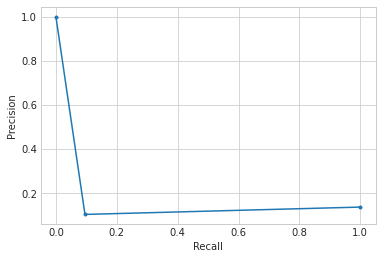

In [139]:

# Initialize empty lists to store evaluation metrics
baseline_precision = []
baseline_recalls = []
baseline_f1_scores = []
baseline_pr_aucs = []

# Perform 1000 random draws
for obs in range(1000):
    
    # Generate random binomial draws with probability 0.137
    draw = np.random.binomial(n=1, p=0.137, size=len(birth_test))
  
    # Calculate precision score and append to the list
    precision_obs = precision_score(birth_test.birth_class_binary, draw)
    baseline_precision.append(precision_obs)

    # Calculate recall score and append to the list
    recall_obs = recall_score(birth_test.birth_class_binary, draw)
    baseline_recalls.append(recall_obs)
    
    # Calculate precision-recall curve and AUC
    base_precision, base_recall, _ = precision_recall_curve(birth_test.birth_class_binary, draw)
    pr_auc = auc(base_recall, base_precision)
    baseline_pr_aucs.append(pr_auc)
    
    # Calculate F1 score and append to the list
    f1 = f1_score(birth_test.birth_class_binary, draw)
    baseline_f1_scores.append(f1)

plt.plot(base_recall,base_precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')

# Print statistics for recall, F1, and PR AUC scores
print("Here are some statistics for our baseline:")

print("Mean Precision - " + str(round(np.mean(baseline_precision), 6)))
print("Median Precision - " + str(round(np.median(baseline_precision), 6)))

print("Mean Recall - " + str(round(np.mean(baseline_recalls), 6)))
print("Median Recall - " + str(round(np.median(baseline_recalls), 6)))

print("Mean F1 Score - " + str(round(np.mean(baseline_f1_scores), 6)))
print("Median F1 Score - " + str(round(np.median(baseline_f1_scores), 6)))

print("Mean PR AUC - " + str(round(np.mean(baseline_pr_aucs), 6)))
print("Median PR AUC - " + str(round(np.median(baseline_pr_aucs), 6)))

## Run Best Model — Logistic Regression with Class Weights

### Defining the model features

These include the following variables:

Continuous:
- Maternal age
- BMI

Categorical:
- Smoking Status
- Drinking frequency
- Binge drinking
- Drug use
- Diabetes
- Mental health
- Birth order

In [134]:
model_feat = ['maternal_age', 'BMI']

# Add one-hot encoded lifestyle features
model_feat.extend(['smoking_status_Non-smoker', 
                   'smoking_status_Smoker', 
                   'smoking_status_Unknown', 
                   'drinking_frequency_2to3Weekly',
                   'drinking_frequency_2to4Monthly',
                   'drinking_frequency_4orMoreWeekly',
                   'drinking_frequency_Monthly',
                   'drinking_frequency_Skipped',
                   'six_or_more_drinks_occurrence_Daily',
                   'six_or_more_drinks_occurrence_LessThanMonthly',
                   'six_or_more_drinks_occurrence_Monthly',
                   'six_or_more_drinks_occurrence_Never',
                   'six_or_more_drinks_occurrence_Skipped',
                   'six_or_more_drinks_occurrence_Weekly',
                   'drug_use_No', 
                   'drug_use_Yes'])

# Add one-hot encoded health features
model_feat.extend(['birth_order_1',
                   'birth_order_2',
                   'birth_order_3',
                   'diabetes_None',
                   'diabetes_Type1',
                   'diabetes_Type2',
                   'diabetes_TypeUnknown',
                   'mental_health_Anxiety',
                   'mental_health_Depression',
                   'mental_health_None',
                   'mental_health_Other'])

### Run Final Model and Print Metrics

--- Final Model Metrics on Test Data ---
Precision:  0.16691068814055637
Recall:  0.4730290456431535
F1:  0.24675324675324678
AUC:  0.19669837874964846
Confusion Matrix: 
[[945 569]
 [127 114]]
 


Text(0, 0.5, 'Precision')

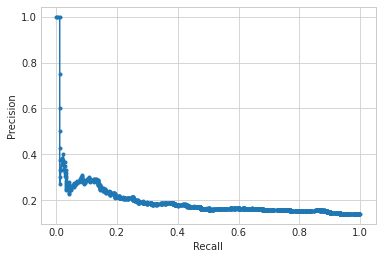

In [138]:
# # Initialize arrays to store evaluation metrics
# prec = np.zeros(num_splits)
# recalls = np.zeros(num_splits)
# f1 = np.zeros(num_splits)
# pr_auc = np.zeros(num_splits)

# # Start counter
# counter = 0

# Loop through each KFold split
# for train_index, test_index in kfold.split(birth_train_encoded, birth_train_encoded.birth_class_binary):
#     birth_tt = birth_train_encoded.iloc[train_index]
#     birth_ho = birth_train_encoded.iloc[test_index]

log_reg = LogisticRegression(penalty='l2', class_weight='balanced', max_iter=1000)

log_reg.fit(birth_train_encoded[model_feat].values, birth_train_encoded.birth_class_binary.values)

pred = log_reg.predict(birth_test_encoded[model_feat].values)

precision = precision_score(birth_test_encoded.birth_class_binary.values, pred)
recall = recall_score(birth_test_encoded.birth_class_binary.values, pred)
f1 = f1_score(birth_test_encoded.birth_class_binary.values, pred)

# Calculate precision-recall curve and AUC
precisions, recalls, _ = precision_recall_curve(birth_test_encoded.birth_class_binary.values, log_reg.predict_proba(birth_test_encoded[model_feat].values)[:,1])
pr_auc = auc(recalls, precisions)

# Calculate confusion matrix
conf_mat = confusion_matrix(birth_test_encoded.birth_class_binary.values, pred)

print('--- Final Model Metrics on Test Data ---')
print('Precision: ', precision)
print('Recall: ', recall)
print('F1: ', f1)
print('AUC: ', pr_auc)
print('Confusion Matrix: ')
print(conf_mat)
print(' ')

plt.plot(recalls,precisions, marker='.', label='Logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')

#Adjust counter for next k-fold split
#counter += 1

## Make plot of model PR-AUC vs baseline PR-AUC

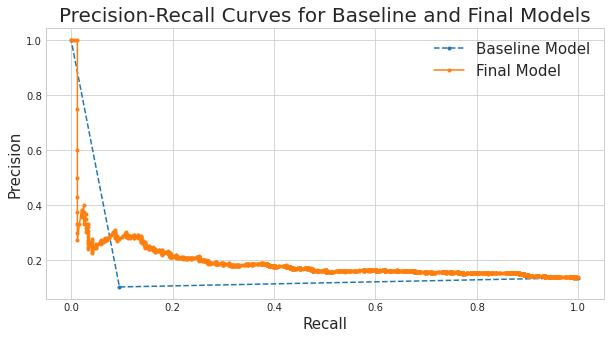

In [151]:
plt.figure(figsize=(10,5))

# Plot baseline
plt.plot(base_recall, base_precision, linestyle='dashed', marker='.', label='Baseline Model')

# Plot model
plt.plot(recalls, precisions, marker='.', label='Final Model')

plt.title('Precision-Recall Curves for Baseline and Final Models', fontsize="20")
plt.xlabel('Recall', fontsize="15")
plt.ylabel('Precision', fontsize="15")
plt.legend(fontsize="15", loc ="upper right")

plt.show()